Here the plan is the decode stimulus intensity, 
training high and low cue decoders
within individuals. 

In [1]:
import os
import re
import json
import glob
from datetime import datetime
from os.path import join
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
import joblib
import h5py

from sklearn.model_selection import GroupKFold, cross_val_score, KFold
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import make_scorer, mean_squared_error

from nilearn import image, masking, plotting
from nilearn.input_data import NiftiLabelsMasker, NiftiMapsMasker
from nilearn.image import resample_to_img, math_img, new_img_like

import neuromaps
from neuromaps import datasets as neuromaps_datasets
from neuromaps.datasets import fetch_annotation, fetch_fslr
from neuromaps.parcellate import Parcellater
from neuromaps.images import dlabel_to_gifti
from neuromaps.transforms import fsaverage_to_fslr

from netneurotools import datasets as nnt_data

from surfplot import Plot

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


/Users/h/miniconda3/envs/spacetop/lib/python3.11/site-packages/nilearn/input_data/__init__.py:23: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


## function

In [2]:
from nilearn import image, plotting
from surfplot import Plot
from neuromaps.transforms import fsaverage_to_fslr
import glob

def plot_brain_surfaces(image, cbar_label='INSERT LABEL', cmap='viridis', color_range=None):
    """
    Plot brain surfaces with the given data.

    Parameters:
    - TST: Tuple of (left hemisphere data, right hemisphere data) to be plotted.
    - cbar_label: Label for the color bar.
    - cmap: Colormap for the data.
    - color_range: Optional. Tuple of (min, max) values for the color range. If not provided, the range is auto-detected.
    """
    surfaces_fslr = fetch_fslr()
    lh_fslr, rh_fslr = surfaces_fslr['inflated']
    
    p = Plot(surf_lh=lh_fslr,
             surf_rh=rh_fslr, 
             size=(1000, 200), 
             zoom=1.2, layout='row', 
             views=['lateral', 'medial', 'ventral', 'posterior'], 
             mirror_views=True, brightness=.7)
    p.add_layer({'left': image[0], 
            'right': image[1]}, 
            cmap=cmap, cbar=True,
            color_range=color_range,
            cbar_label=cbar_label
            ) # YlOrRd_r

    cbar_kws = dict(outer_labels_only=True, pad=.02, n_ticks=2, decimals=3)
    fig = p.build(cbar_kws=cbar_kws)
    fig.show()

# Example usage:
# TST = (left_hemisphere_data, right_hemisphere_data)
# plot_brain_surfaces(TST, cbar_label='gradient', cmap='viridis', color_range=(0, .15))


# Multiclass clssification using sklearn
1. Classify pain, vicarious, cognitive maps based on single trials 
2. Classify pain, vicarious, cogntiive maps based on contrast maps

In [6]:
current_dir = os.getcwd()
current_dir
main_dir = Path(current_dir).parents[1]

# pipeline for multiclass
* load single trials
* Parcellate 
* save data into array with metadaa
* apply crossvalidation on data

In [6]:
singletrial_dir = '/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/singletrial_rampupdown/'
# sub = "sub-0101"
subdirectories = glob.glob(join(singletrial_dir, "sub-*"))
flists = []
for subdir in subdirectories:
    sub = os.path.basename(subdir)
    flist = glob.glob(join(singletrial_dir, sub, f"{sub}_ses-*_run-*_runtype-*_event-stimulus_trial-*_cuetype-*_stimintensity-*.nii.gz"))
    flists.append(flist)

flattened_list = [item for sublist in flists for item in sublist]


In [7]:
flattened_list[0]

'/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/singletrial_rampupdown/sub-0117/sub-0117_ses-01_run-02_runtype-cognitive_event-stimulus_trial-006_cuetype-low_stimintensity-med.nii.gz'

# run only once - extract parcel value from roi

In [51]:
# schaefer = nntdata.fetch_schaefer2018('fslr32k')['400Parcels7Networks']
# parcelarray = []
# metadata = []
# for fname in flattened_list:
#     metadata.append(os.path.basename(fname))
#     singletrialFSLR = neuromaps.transforms.mni152_to_fslr(fname, fslr_density='32k', method='linear')
#     parc = Parcellater(dlabel_to_gifti(schaefer), 'fsLR')
#     singletrial_parc = parc.fit_transform(singletrialFSLR, 'fsLR')
#     parcelarray.append(singletrial_parc)

pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-

# load data (MUST)

In [3]:
current_dir = os.getcwd()
current_dir
main_dir = Path(current_dir).parents[1] 
print(main_dir)
from neuromaps.images import dlabel_to_gifti, annot_to_gifti
from neuromaps import transforms
# /Users/h/Documents/projects_local/cue_expectancy/analysis/fmri/nilearn/deriv02_parcel-schaefer400/singletrial_rampupplateau_task-pvc_atlas-schaefer2018.npy'
brain_glasser = np.load(join(main_dir, 'analysis/fmri/nilearn/deriv02_parcel-glasser', 'singletrial_rampupplateau_task-pvc_epoch-stimulus_atlas-glasser.npy'))
brain_subcortexdf = np.load(join(main_dir, 'analysis/fmri/nilearn/deriv02_parcel-canlab2023subcortex', 
                                  'singletrial_rampupplateau_task-pvc_epoch-stimulus_atlas-canlab2023subcortex.npy'))
print(f"the shape of the parcel data {brain_glasser.shape}")
df_singletrial = pd.read_csv(join(main_dir, 'analysis/fmri/nilearn/deriv02_parcel-glasser', 
                                  'singletrial_rampupplateau_task-pvc_epoch-stimulus_atlas-glasser.tsv'), sep='\t')
df_singletrial_subcortex = pd.read_csv(join(main_dir, 'analysis/fmri/nilearn/deriv02_parcel-canlab2023subcortex', 
                                  'singletrial_rampupplateau_task-pvc_epoch-stimulus_atlas-canlab2023subcortex.tsv'), sep='\t')
hcplh = annot_to_gifti('/Users/h/Documents/projects_local/cue_expectancy/data/atlas/lh.HCP-MMP1.annot')
hcprh = annot_to_gifti('/Users/h/Documents/projects_local/cue_expectancy/data/atlas/rh.HCP-MMP1.annot')
HCP_fslr_lh = transforms.fsaverage_to_fslr(hcplh, hemi='L', target_density='32k', method='nearest')
HCP_fslr_rh = transforms.fsaverage_to_fslr(hcprh, hemi='R', target_density='32k', method='nearest')
HCP_fslr_rh_update = HCP_fslr_rh
HCP_fslr_rh_update[0].darrays[0].data = np.where(HCP_fslr_rh[0].agg_data() != 0, HCP_fslr_rh[0].agg_data() + 180, HCP_fslr_rh[0].agg_data())
hcp_glasser = (HCP_fslr_lh[0], HCP_fslr_rh_update[0])

# %% apply parcellation
canlab2023 = '/Users/h/Documents/projects_local/cue_expectancy/data/atlas/CANLab2023_MNI152NLin6Asym_coarse_2mm_cifti_vols.nii.gz'

HCPparc = Parcellater(hcp_glasser, 'fsLR', resampling_target='parcellation')
subcortexparc = Parcellater(parcellation=canlab2023, 
                       space='MNI152', 
                       resampling_target='parcellation')

df_beh = pd.read_csv('/Users/h/Documents/projects_local/cue_expectancy/data/beh/sub-all_task-all_events.tsv', sep='\t')

/Users/h/Documents/projects_local/cue_expectancy
the shape of the parcel data (17111, 360)


In [4]:
# Adjusting the function to include prefixes for sub, ses, and run in the output
def parse_filename_with_regex_adjusted(filename):
    # Updated regular expression pattern to keep the prefixes in the extracted values
    pattern = r"(sub-\d+)_(ses-\d+)_(run-\d+)_runtype-(\w+)_event-(\w+)_trial-(\d+)_cuetype-(\w+)_stimintensity-(\w+)"
    match = re.match(pattern, filename)
    
    if match:
        metadata = {
            'sub': match.group(1),  # Keeping the prefix for sub
            'ses':  match.group(2),  # Adding 'ses-' prefix
            'run':  match.group(3),  # Adding 'run-' prefix
            'runtype': match.group(4),
            'event': match.group(5),
            'trial_index': int(match.group(6)),  # Convert trial_index to integer
            'cue': match.group(7) + '_cue',  # Append "_cue" to cue value
            'stimulusintensity': match.group(8) + '_stim',  # Append "_stim" to stimulusintensity value
        }
        return metadata
    else:
        return {}

# Test the adjusted function with the sample filename
df_parsed = (df_singletrial['singletrial_fname']).apply(parse_filename_with_regex_adjusted).apply(pd.Series)
df_cortex = pd.concat([df_singletrial['singletrial_fname'], df_parsed], axis=1)

df_parsed_subcortex = (df_singletrial_subcortex['singletrial_fname']).apply(parse_filename_with_regex_adjusted).apply(pd.Series)
df_subcortex = pd.concat([df_singletrial_subcortex['singletrial_fname'], df_parsed_subcortex], axis=1)

brain_metadf = pd.merge(df_cortex, df_subcortex, on=["singletrial_fname", "sub", "ses", "run", "runtype", "event", "trial_index", "cue", "stimulusintensity"], how="inner")


In [5]:
df_subcortex.head()
df_cortex.head()
brain_metadf.head()

,singletrial_fname,sub,ses,run,runtype,event,trial_index,cue,stimulusintensity
0,sub-0002_ses-03_run-02_runtype-pain_event-stim...,sub-0002,ses-03,run-02,pain,stimulus,9,high_cue,high_stim
1,sub-0002_ses-04_run-05_runtype-cognitive_event...,sub-0002,ses-04,run-05,cognitive,stimulus,10,low_cue,med_stim
2,sub-0002_ses-04_run-02_runtype-cognitive_event...,sub-0002,ses-04,run-02,cognitive,stimulus,5,low_cue,low_stim
3,sub-0002_ses-04_run-05_runtype-cognitive_event...,sub-0002,ses-04,run-05,cognitive,stimulus,6,low_cue,high_stim
4,sub-0002_ses-03_run-03_runtype-cognitive_event...,sub-0002,ses-03,run-03,cognitive,stimulus,7,high_cue,high_stim


In [6]:
df_beh_modified = df_beh.drop('trial_index', axis=1)
df_parsed_beh = (df_beh_modified['singletrial_fname']).apply(parse_filename_with_regex_adjusted).apply(pd.Series)
# beh_merge = pd.concat([df_beh_modified, df_parsed_beh], axis=1)
beh_merge = pd.merge(df_beh_modified, df_parsed_beh, on=[ "sub", "ses", "run", "runtype", "cue", "stimulusintensity"], how="inner")

In [7]:
beh_merge

,sub,ses,run,runtype,cue,stimulusintensity,singletrial_fname,expectrating,expectlabel,outcomerating,outcomelabel,event,trial_index
0,sub-0002,ses-03,run-01,vicarious,low_cue,low_stim,sub-0002_ses-03_run-01_runtype-vicarious_event...,NaN,NaN,NaN,NaN,stimulus,0
1,sub-0002,ses-03,run-01,vicarious,low_cue,low_stim,sub-0002_ses-03_run-01_runtype-vicarious_event...,NaN,NaN,NaN,NaN,stimulus,11
2,sub-0002,ses-03,run-01,vicarious,low_cue,low_stim,sub-0002_ses-03_run-01_runtype-vicarious_event...,18.51,Moderate,10.68,Moderate,stimulus,0
3,sub-0002,ses-03,run-01,vicarious,low_cue,low_stim,sub-0002_ses-03_run-01_runtype-vicarious_event...,18.51,Moderate,10.68,Moderate,stimulus,11
4,sub-0002,ses-03,run-01,vicarious,high_cue,med_stim,sub-0002_ses-03_run-01_runtype-vicarious_event...,NaN,NaN,32.54,Strong,stimulus,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
35851,sub-0133,ses-04,run-06,cognitive,high_cue,med_stim,sub-0133_ses-04_run-06_runtype-cognitive_event...,41.92,Strong,9.24,Weak,stimulus,9
35852,sub-0133,ses-04,run-06,cognitive,low_cue,low_stim,sub-0133_ses-04_run-06_runtype-cognitive_event...,8.13,Weak,5.05,Weak,stimulus,8
35853,sub-0133,ses-04,run-06,cognitive,low_cue,low_stim,sub-0133_ses-04_run-06_runtype-cognitive_event...,8.13,Weak,5.05,Weak,stimulus,11
35854,sub-0133,ses-04,run-06,cognitive,low_cue,low_stim,sub-0133_ses-04_run-06_runtype-cognitive_event...,1.39,Barely detectable,4.63,Weak,stimulus,8


## merge data

In [8]:
braindf = np.hstack([brain_glasser, brain_subcortexdf]) # merge brain numpys
brain_metadf['index'] = brain_metadf.index
print(brain_metadf['singletrial_fname'][0])
print(beh_merge['singletrial_fname'][0])

print(df_singletrial.shape)
print(beh_merge.shape)
# brain_metadf['trial_index'] = brain_metadf['trial'].str.extract(r'trial-(\d+)').astype(int)
print(f"columns df_beh: {df_beh.columns}")
print(f"columns df_singletrial: {df_singletrial.columns}")

merged_df = pd.merge(brain_metadf, beh_merge, on=["singletrial_fname", "sub", "ses", "run", "runtype", "trial_index", "event", "cue", "stimulusintensity"], how="inner")
print(merged_df.shape)
merged_df.head()
# make sure the beh+NPS data is in the parcel data


cleanbraindf = braindf[merged_df['index'].tolist()]
print(f"brain df shape: {cleanbraindf.shape}")
print(f"behavioral - brain intersection shape: {merged_df.shape}")


sub-0002_ses-03_run-02_runtype-pain_event-stimulus_trial-009_cuetype-high_stimintensity-high.nii.gz
sub-0002_ses-03_run-01_runtype-vicarious_event-stimulus_trial-000_cuetype-low_stimintensity-low.nii.gz
(17111, 8)
(35856, 13)
columns df_beh: Index(['sub', 'ses', 'run', 'runtype', 'trial_index', 'cue',
       'stimulusintensity', 'singletrial_fname', 'expectrating', 'expectlabel',
       'outcomerating', 'outcomelabel'],
      dtype='object')
columns df_singletrial: Index(['singletrial_fname', 'sub', 'ses', 'run', 'runtype', 'event', 'trial',
       'cuetype'],
      dtype='object')
(17111, 14)
brain df shape: (17111, 526)
behavioral - brain intersection shape: (17111, 14)


## 0-2 plot behavioral data

In [9]:
merged_df['stim_con'] = merged_df['stimulusintensity'].replace({'high_stim':1, 
                                           'med_stim':0, 
                                           'low_stim':-1})
merged_df['cue_con'] = merged_df['cue'].replace({'high_cue':1, 
                                           'low_cue':-1})   
cleanbehdf = merged_df
print(f"column names: {merged_df.columns}")
print(f"take a look at the beh + NPS dataframe: {merged_df.head()}")


column names: Index(['singletrial_fname', 'sub', 'ses', 'run', 'runtype', 'event',
       'trial_index', 'cue', 'stimulusintensity', 'index', 'expectrating',
       'expectlabel', 'outcomerating', 'outcomelabel', 'stim_con', 'cue_con'],
      dtype='object')
take a look at the beh + NPS dataframe:                                    singletrial_fname       sub     ses  \
0  sub-0002_ses-03_run-02_runtype-pain_event-stim...  sub-0002  ses-03   
1  sub-0002_ses-04_run-05_runtype-cognitive_event...  sub-0002  ses-04   
2  sub-0002_ses-04_run-02_runtype-cognitive_event...  sub-0002  ses-04   
3  sub-0002_ses-04_run-05_runtype-cognitive_event...  sub-0002  ses-04   
4  sub-0002_ses-03_run-03_runtype-cognitive_event...  sub-0002  ses-03   

      run    runtype     event  trial_index       cue stimulusintensity  \
0  run-02       pain  stimulus            9  high_cue         high_stim   
1  run-05  cognitive  stimulus           10   low_cue          med_stim   
2  run-02  cognitive  stimulus 

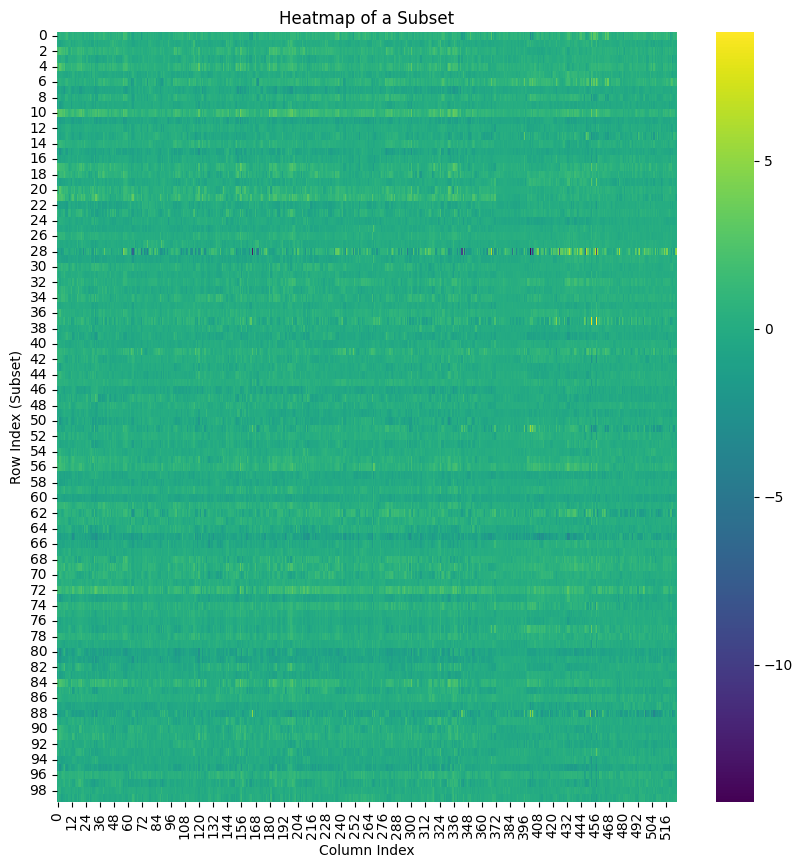

In [10]:
import seaborn as sns

# Selecting a subset (e.g., first 100 rows)
subset = cleanbraindf[:100, :]

plt.figure(figsize=(10, 10))
sns.heatmap(subset, cmap='viridis', cbar=True)
plt.title('Heatmap of a Subset')
plt.xlabel('Column Index')
plt.ylabel('Row Index (Subset)')
plt.show()


In [11]:
cleanbehdf.head()

,singletrial_fname,sub,ses,run,runtype,event,trial_index,cue,stimulusintensity,index,expectrating,expectlabel,outcomerating,outcomelabel,stim_con,cue_con
0,sub-0002_ses-03_run-02_runtype-pain_event-stim...,sub-0002,ses-03,run-02,pain,stimulus,9,high_cue,high_stim,0,87.26,Very Strong,70.33,Very Strong,1,1
1,sub-0002_ses-04_run-05_runtype-cognitive_event...,sub-0002,ses-04,run-05,cognitive,stimulus,10,low_cue,med_stim,1,40.19,Strong,46.57,Strong,0,-1
2,sub-0002_ses-04_run-02_runtype-cognitive_event...,sub-0002,ses-04,run-02,cognitive,stimulus,5,low_cue,low_stim,2,NaN,NaN,NaN,NaN,-1,-1
3,sub-0002_ses-04_run-05_runtype-cognitive_event...,sub-0002,ses-04,run-05,cognitive,stimulus,6,low_cue,high_stim,3,NaN,NaN,NaN,NaN,1,-1
4,sub-0002_ses-03_run-03_runtype-cognitive_event...,sub-0002,ses-03,run-03,cognitive,stimulus,7,high_cue,high_stim,4,27.69,Moderate,7.61,Weak,1,1


# 1 session wise cue difference

In [50]:
# subset data with high cues
high_cue_pain_index = cleanbehdf[(cleanbehdf['runtype'] == 'pain') & (cleanbehdf['cue'] == 'high_cue')].index
df_pain_highcue = cleanbehdf[(cleanbehdf['runtype'] == 'pain') & (cleanbehdf['cue'] == 'high_cue')].copy().reset_index(drop=True)
# build model per "sub"
examplesub = df_pain_highcue[df_pain_highcue['sub'] == 'sub-0133']


Yinterim, uniques = pd.factorize(df_pain_highcue['stimulusintensity'])
# use "run" as grouping factor
groups = pd.factorize(df_pain_highcue['run'])
X = braindf[high_cue_pain_index]
Y = Yinterim


# balancer
some participants don't have equal number of trials
we balance it here

In [52]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupKFold
from sklearn.utils import resample

# Given variables: X (data array), Y (factorized labels), groups (array of group labels)

# Convert groups to an array if it's not already
groups_array = np.array(groups[0])

# Find unique groups
unique_groups = np.unique(groups_array)

# Initialize lists to hold the balanced dataset
X_balanced = []
Y_balanced = []
groups_balanced = []

for group in unique_groups:
    # print(group)
    # Indices for the current group
    group_indices = np.where(groups_array == group)[0]
    print(group)
    # Extract current group's data and labels
    X_group = X[group_indices]
    Y_group = Y[group_indices]
    
    # Get the smallest class size within this group
    min_class_size = min(np.bincount(Y_group).min(), group_indices.size)
    if min_class_size > 0:
        # Initialize temporary lists for the group's balanced data
        X_group_balanced = []
        Y_group_balanced = []
        
        # Balance each class within the group
        for class_label in np.unique(Y_group):
            # print(class_label)
            # Indices for the current class within the group
            class_indices = np.where(Y_group == class_label)[0]
            
            # Resample the class to the target size
            resampled_indices = resample(class_indices, n_samples=min_class_size, replace=False, random_state=42)
            
            # Append resampled data and labels to the group's temporary lists
            X_group_balanced.append(X_group[resampled_indices])
            Y_group_balanced.append(Y_group[resampled_indices])
        
        # Concatenate balanced data for the current group and append to the overall balanced lists
        X_balanced.append(np.vstack(X_group_balanced))
        Y_balanced.append(np.concatenate(Y_group_balanced))
        groups_balanced += [group] * min_class_size * len(np.unique(Y_group))
    else:
        print("f{group} does not have trials in one of the classes")

# Concatenate all balanced data from each group to form the final balanced dataset
X_balanced = np.vstack(X_balanced)
Y_balanced = np.concatenate(Y_balanced)
groups_balanced = np.array(groups_balanced)

# Now, X_balanced, Y_balanced, and groups_balanced contain your balanced dataset respecting the original group structure


0
1
2
3
4
5


In [53]:
# Check frequency of balanced data

# 1) Count the number of Y values per group
unique_groups = np.unique(groups_balanced)
group_counts = {group: np.bincount(Y_balanced[groups_balanced == group], minlength=len(np.unique(Y_balanced))) for group in unique_groups}

# 2) Convert to DataFrame for nicer display
df_group_counts = pd.DataFrame(group_counts, index=[f'Class {i}' for i in range(len(np.unique(Y_balanced)))])

df_group_counts


,0,1,2,3,4,5
Class 0,154,132,143,150,139,142
Class 1,154,132,143,150,139,142
Class 2,154,132,143,150,139,142


In [33]:
len(unique_groups)

5

# SVM (classification)

In [34]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import time

# This code essentially performs 10-fold cross-validation with a Support Vector Machine classifier 
# to evaluate the model's performance on the given brain data and labels, ensuring that the cross-
# validation process is stratified and group-wise. The mean accuracy provides an estimate of how 
# well the SVM model generalizes to unseen data.
# # X: brain data. shape: (number of trials, number of voxels)
# # Y: 1D array with labels (0 for pain, 1 for vicarious, 2 for cognitive)

# 10-fold stratified cross validation
# folds are applied on subject level data
# A linear SVM classifer is trained on the training data and applied on the test data, by predicting 
# the labels on the test data. Accuracies compiles the model accuracy of predicting the labels across the 10 folds. 


# Initialize arrays to store results
accuracies = []



start_time = time.perf_counter()
outer_cv = GroupKFold(n_splits=len(unique_groups))
# pls_model = PLSRegression(n_components=3)
i = 0
scores = []
weights_per_fold = []
coefficients = []
yloadings = []
y_pred_probas = []
y_tests = []
for i, (train_idx, test_idx) in enumerate(outer_cv.split(X_balanced, Y_balanced, groups_balanced)):
    X_train, X_test = X_balanced[train_idx], X_balanced[test_idx]
    Y_train, Y_test = Y_balanced[train_idx], Y_balanced[test_idx]
    
    # Initialize and train a Support Vector Machine (SVM) classifier
    svm = SVC(kernel='linear', decision_function_shape='ovr')  # One-vs-Rest
    svm.fit(X_train, Y_train)
    
    # Predict using the trained model
    Y_pred = svm.predict(X_test)
    accuracy = accuracy_score(Y_test, Y_pred)
    accuracies.append(accuracy)
    weights = svm.coef_
    weights_per_fold.append(weights)
    y_tests.append(Y_test)
# Calculate the mean accuracy across all folds
mean_accuracy = np.mean(accuracies)

# Display the mean accuracy
print(f"Mean Accuracy: {mean_accuracy * 100:.2f}%")
end_time = time.perf_counter()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")


Mean Accuracy: 53.33%
Elapsed time: 0.01564412900188472 seconds


In [35]:
accuracies

[0.3333333333333333, 0.6666666666666666, 0.6666666666666666, 0.5, 0.5]

In [36]:
uniques

Index(['high_stim', 'low_stim', 'med_stim'], dtype='object')

# combined code with subsetting sub, "run" as group, and cross validate

Elapsed time: 0.2611891749984352 seconds
         sub  accuracy
0   sub-0015  0.250000
1   sub-0016  0.333333
2   sub-0025  0.333333
3   sub-0028  0.500000
4   sub-0029  0.000000
..       ...       ...
67  sub-0128  0.416667
68  sub-0129  0.666667
69  sub-0130  0.416667
70  sub-0132  0.333333
71  sub-0133  0.250000

[72 rows x 2 columns]


/Users/h/miniconda3/envs/spacetop/lib/python3.11/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


<Axes: >

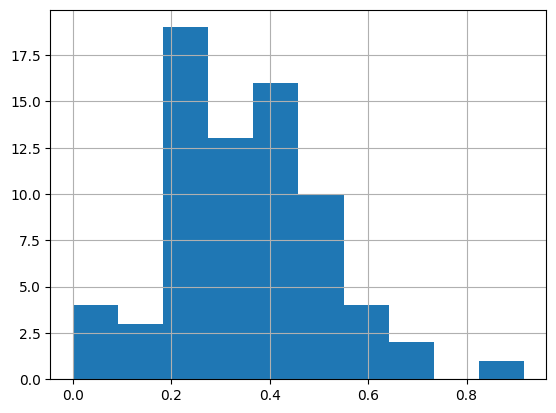

In [73]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import time


# Filter for 'pain' runtype and 'high_cue' only
df_pain_highcue = cleanbehdf[(cleanbehdf['runtype'] == 'pain') & (cleanbehdf['cue'] == 'high_cue')  & (cleanbehdf['ses'] == 'ses-01')].copy()
overall_results = []
start_time = time.perf_counter()

# subset data with high cues
high_cue_pain_index = cleanbehdf[(cleanbehdf['runtype'] == 'pain') & (cleanbehdf['cue'] == 'high_cue')].index

runs_per_sub = df_pain_highcue.groupby('sub')['run'].nunique()
subs_to_drop = runs_per_sub[runs_per_sub <= 1].index

# Filter out participants with only one run
df_filtered = df_pain_highcue[~df_pain_highcue['sub'].isin(subs_to_drop)]
# Loop over each subject
for sub in df_filtered['sub'].unique():
    # Subset data for the current subject
    df_sub = df_pain_highcue[df_pain_highcue['sub'] == sub]
    
    # Ensure corresponding brain data is selected
    X = braindf[df_sub.index]
    Y, uniques = pd.factorize(df_sub['stimulusintensity'])
    
    # Optionally, perform cross-validation within this subject's data
    accuracies = []
    
    cv = StratifiedKFold(n_splits=len(df_sub['run'].unique()), shuffle=True, random_state=42)
    
    for train_idx, test_idx in cv.split(X, Y):
        X_train, X_test = X[train_idx], X[test_idx]
        Y_train, Y_test = Y[train_idx], Y[test_idx]
        
        # Initialize and train the SVM model
        svm = SVC(kernel='linear')
        svm.fit(X_train, Y_train)
        
        # Predict and evaluate
        Y_pred = svm.predict(X_test)
        accuracies.append(accuracy_score(Y_test, Y_pred))
    
    # Store the mean accuracy for this subject
    mean_accuracy = np.mean(accuracies)
    overall_results.append({'sub': sub, 'accuracy': mean_accuracy})

# Convert overall results to a DataFrame for easier analysis and visualization
results_df = pd.DataFrame(overall_results)

elapsed_time = time.perf_counter() - start_time
print(f"Elapsed time: {elapsed_time} seconds")
print(results_df)
results_df.accuracy.hist()

Elapsed time: 0.22790279101172928 seconds
         sub  accuracy
0   sub-0015  0.250000
1   sub-0016  0.166667
2   sub-0025  0.266667
3   sub-0028  0.166667
4   sub-0029  0.333333
..       ...       ...
67  sub-0128  0.583333
68  sub-0129  0.533333
69  sub-0130  0.500000
70  sub-0132  0.000000
71  sub-0133  0.333333

[72 rows x 2 columns]


<Axes: >

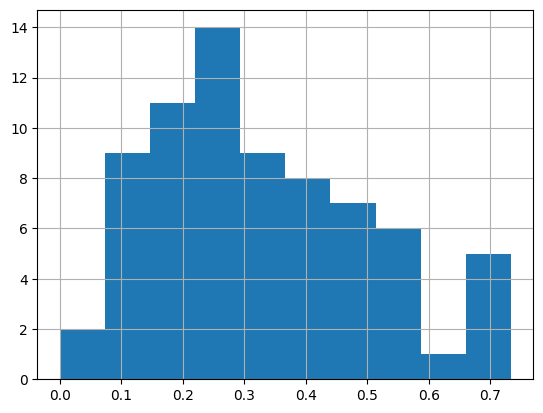

In [75]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import time


# Filter for 'pain' runtype and 'high_cue' only
df_pain_highcue = cleanbehdf[(cleanbehdf['runtype'] == 'pain') & (cleanbehdf['cue'] == 'low_cue') & (cleanbehdf['ses'] == 'ses-01')].copy()
overall_results = []
start_time = time.perf_counter()

# subset data with high cues
high_cue_pain_index = cleanbehdf[(cleanbehdf['runtype'] == 'pain') & (cleanbehdf['cue'] == 'low_cue')].index

runs_per_sub = df_pain_highcue.groupby('sub')['run'].nunique()
subs_to_drop = runs_per_sub[runs_per_sub <= 1].index

# Filter out participants with only one run
df_filtered = df_pain_highcue[~df_pain_highcue['sub'].isin(subs_to_drop)]
# Loop over each subject
for sub in df_filtered['sub'].unique():
    # Subset data for the current subject
    df_sub = df_pain_highcue[df_pain_highcue['sub'] == sub]
    
    # Ensure corresponding brain data is selected
    X = braindf[df_sub.index]
    Y, uniques = pd.factorize(df_sub['stimulusintensity'])
    
    # Optionally, perform cross-validation within this subject's data
    accuracies = []
    
    cv = StratifiedKFold(n_splits=len(df_sub['run'].unique()), shuffle=True, random_state=42)
    
    for train_idx, test_idx in cv.split(X, Y):
        X_train, X_test = X[train_idx], X[test_idx]
        Y_train, Y_test = Y[train_idx], Y[test_idx]
        
        # Initialize and train the SVM model
        svm = SVC(kernel='linear')
        svm.fit(X_train, Y_train)
        
        # Predict and evaluate
        Y_pred = svm.predict(X_test)
        accuracies.append(accuracy_score(Y_test, Y_pred))
    
    # Store the mean accuracy for this subject
    mean_accuracy = np.mean(accuracies)
    overall_results.append({'sub': sub, 'accuracy': mean_accuracy})

# Convert overall results to a DataFrame for easier analysis and visualization
results_df = pd.DataFrame(overall_results)

elapsed_time = time.perf_counter() - start_time
print(f"Elapsed time: {elapsed_time} seconds")
print(results_df)
results_df.accuracy.hist()


In [69]:
results_df

,sub,accuracy
0,sub-0005,0.291667
1,sub-0013,0.375000
2,sub-0014,0.416667
3,sub-0015,0.250000
4,sub-0016,0.267857
...,...,...
90,sub-0129,0.371429
91,sub-0130,0.332143
92,sub-0131,0.333333
93,sub-0132,0.375000


<Axes: >

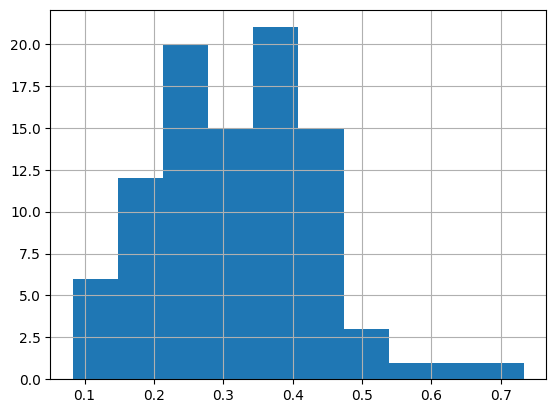

In [71]:
results_df.accuracy.hist()

## SVM-1. Confusion matrix

In [64]:
accuracies

[0.375,
 0.5714285714285714,
 0.42857142857142855,
 0.42857142857142855,
 0.2857142857142857]

In [65]:
original_class_names = np.array(uniques)
# The desired order for the classes
desired_class_order = ['high_stim', 'med_stim', 'low_stim'
                       ]


# Create a dictionary that maps the original indices to the desired class order
class_mapping = {np.where(uniques == name)[0][0]: desired_index
                 for desired_index, name in enumerate(desired_class_order)}
# Create a dictionary that maps the original indices to the desired class order, safely handling cases where no match is found
# class_mapping = {}
# for desired_index, name in enumerate(desired_class_order):
#     where_result = np.where(uniques == name)[0]
#     if len(where_result) > 0:  # Check if any match was found
#         class_mapping[where_result[0]] = desired_index
#     else:
#         print(f"Warning: '{name}' not found in 'uniques'")


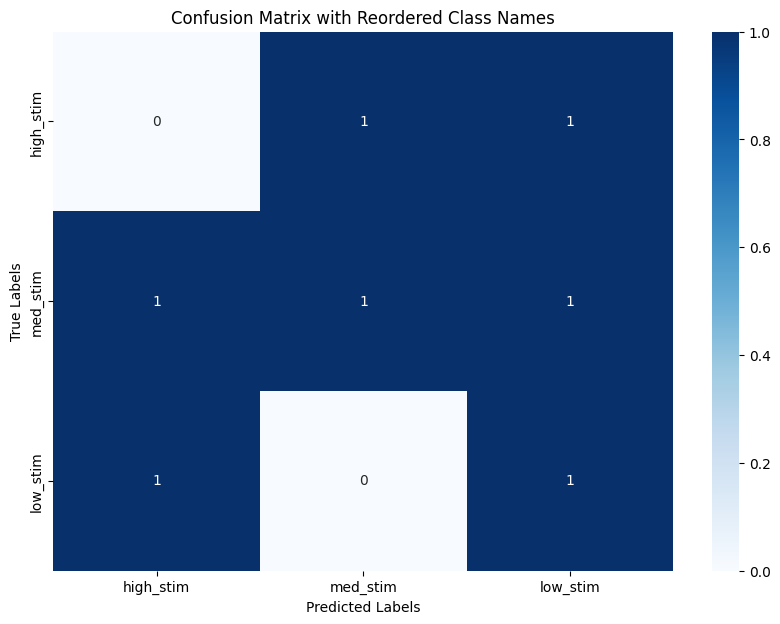

In [66]:


Y_test_remapped = np.vectorize(class_mapping.get)(Y_test)
Y_pred_remapped = np.vectorize(class_mapping.get)(Y_pred)

# Compute the confusion matrix using the remapped labels
cm = confusion_matrix(Y_test_remapped, Y_pred_remapped)

# Plotting the confusion matrix with class labels in the desired order
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=desired_class_order, yticklabels=desired_class_order)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix with Reordered Class Names')
plt.show()

## SVM-2. roc curve

In [39]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# This code essentially performs 10-fold cross-validation with a Support Vector Machine classifier 
# to evaluate the model's performance on the given brain data and labels, 
# ensuring that the cross-validation process is stratified and group-wise. 
# The mean accuracy provides an estimate of how well the SVM model generalizes to unseen data.
# # X: brain data. shape: (number of trials, number of voxels)
# # Y: 1D array with labels (0 for pain, 1 for vicarious, 2 for cognitive)

# 10-fold stratified cross validation
# folds are applied on subject level data
# A linear SVM classifer is trained on the training data and applied on the test data, by predicting the labels on the test data.
# accuracies compiles the model accuracy of predicting the labels across the 10 folds. 


# Initialize arrays to store results
accuracies = []

# Loop through each fold

import time
start_time = time.perf_counter()
outer_cv = GroupKFold(n_splits=10)
# pls_model = PLSRegression(n_components=3)
i = 0
# scores = []
# weights_per_fold = []
# coefficients = []
# yloadings = []
# y_pred_probas = []
# y_tests = []
roc_y_true = []
roc_y_proba = []
for i, (train_idx, test_idx) in enumerate(outer_cv.split(X_balanced, Y_balanced, groups_balanced)):
    roc_X_train, roc_X_test = X_balanced[train_idx], X_balanced[test_idx]
    roc_Y_train, roc_Y_test = Y_balanced[train_idx], Y_balanced[test_idx]
    
    # Initialize and train a Support Vector Machine (SVM) classifier
    roc_svm = SVC(kernel='linear', decision_function_shape='ovr', probability=True)  # One-vs-Rest
    roc_svm.fit(roc_X_train, roc_Y_train)
    
    # Predict using the trained model
    Y_pred_proba = roc_svm.predict_proba(roc_X_test)
    y_pred_probas.append(Y_pred_proba)
    # Store the true labels and probabilities
    roc_y_true.extend(roc_Y_test)
    roc_y_proba.extend(Y_pred_proba)

end_time = time.perf_counter()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")

roc_np_y_true = np.array(roc_y_true)
roc_np_y_proba = np.array(roc_y_proba)



Elapsed time: 7270.174243005 seconds


## SVM-3. plotting weigthmaps

In [120]:
uniques

Index(['ses-03_high_cue', 'ses-03_low_cue', 'ses-04_low_cue',
       'ses-04_high_cue', 'ses-01_high_cue', 'ses-01_low_cue'],
      dtype='object')

In [122]:
weights_per_fold[0].shape

(15, 526)

In [125]:

ses3_cuehigh = HCPparc.inverse_transform(weights_per_fold[0][0][:360])
ses3_cuelow = HCPparc.inverse_transform(weights_per_fold[0][1][:360])
ses4_cuelow = HCPparc.inverse_transform(weights_per_fold[0][2][:360])
ses4_cuehigh = HCPparc.inverse_transform(weights_per_fold[0][3][:360])
ses1_cuehigh = HCPparc.inverse_transform(weights_per_fold[0][4][:360])
ses1_cuelow = HCPparc.inverse_transform(weights_per_fold[0][5][:360])


/var/folders/bv/b3r94k7n0bq727c1_2xtykpw0000gp/T/ipykernel_42531/639931005.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/var/folders/bv/b3r94k7n0bq727c1_2xtykpw0000gp/T/ipykernel_42531/639931005.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/var/folders/bv/b3r94k7n0bq727c1_2xtykpw0000gp/T/ipykernel_42531/639931005.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/var/folders/bv/b3r94k7n0bq727c1_2xtykpw0000gp/T/ipykernel_42531/639931005.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/var/folders/bv/b3r94k7n0bq727c1_2xtykpw0000gp/T/ipykernel_42531/639931005.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/var/folders/bv/b3r94k7n0bq727c1_2xtykpw0000gp/T/ipykernel_42531/639931005.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown

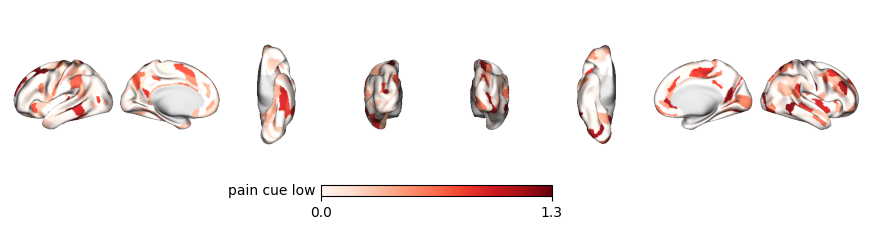

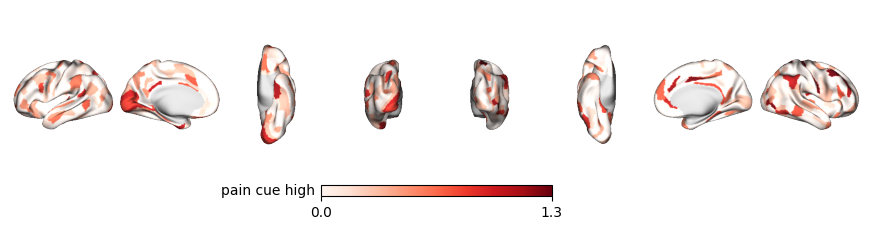

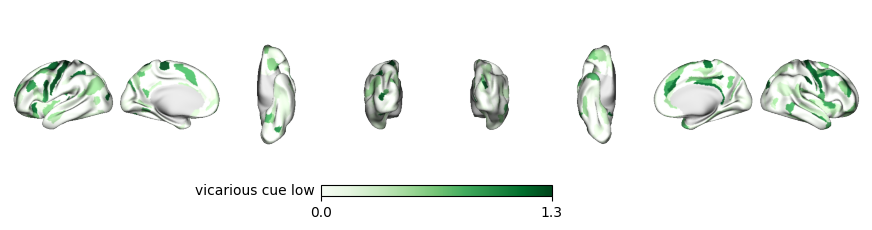

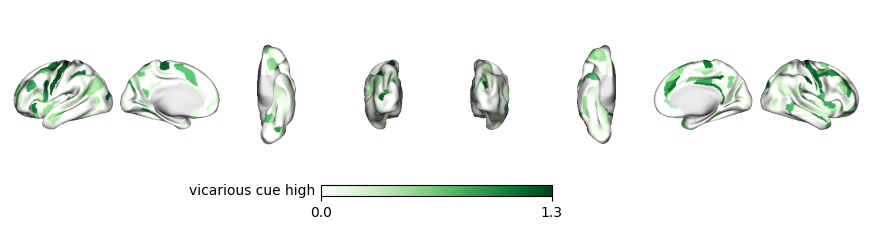

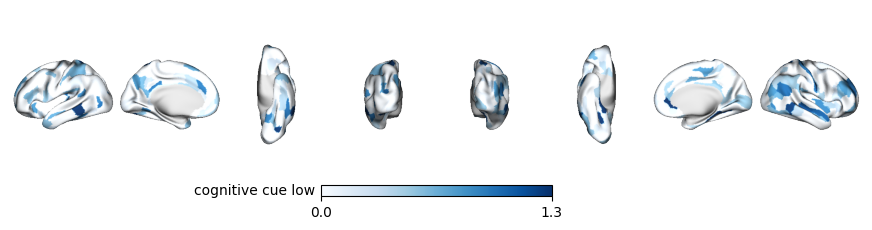

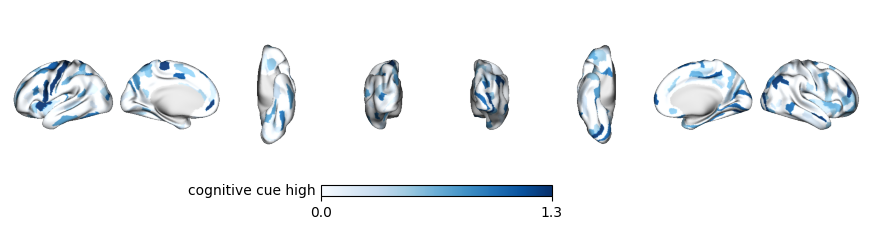

In [126]:
# Assuming 'weights_original_space' is the weights projected back to the original space



# Use this value to define the color range centered around zero
# color_range = (-max_abs_weight, max_abs_weight)
color_range = (0,1.3)
plot_brain_surfaces(image=ses4_cuehigh, cbar_label='pain cue low', cmap='Reds', color_range=color_range)

plot_brain_surfaces(image=ses3_cuehigh, cbar_label='pain cue high', cmap='Reds', color_range=color_range)

plot_brain_surfaces(image=ses4_cuelow, cbar_label='vicarious cue low', cmap='Greens',  color_range=color_range)

plot_brain_surfaces(image=ses4_cuelow, cbar_label='vicarious cue high', cmap='Greens',  color_range=color_range)

plot_brain_surfaces(image=ses1_cuehigh, cbar_label='cognitive cue low', cmap='Blues',  color_range=color_range)

plot_brain_surfaces(image=ses1_cuelow, cbar_label='cognitive cue high', cmap='Blues',  color_range=color_range)

## SVM-4. permutation

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
import numpy as np

n_permutations = 1000
accuracies_permuted = []

for i in range(n_permutations):
    # Shuffle the labels
    Y_permuted = shuffle(Y_balanced)
    
    # Perform cross-validation with the permuted labels
    cv = StratifiedKFold(n_splits=10)
    acc_scores_permute = []
    
    for train_idx, test_idx in cv.split(X_balanced, Y_permuted):
        X_train, X_test = X_balanced[train_idx], X_balanced[test_idx]
        Y_train, Y_test = Y_permuted[train_idx], Y_permuted[test_idx]
        
        svm_permute = SVC(kernel='linear', decision_function_shape='ovr').fit(X_train, Y_train)
        Y_pred_permute = svm_permute.predict(X_test)
        
        acc_scores_permute.append(accuracy_score(Y_test, Y_pred_permute))
    
    # Store the mean accuracy for this permutation
    accuracies_permuted.append(np.mean(acc_scores_permute))

# Calculate the empirical p-value
original_accuracy = 20.67# (Your model's original accuracy)
p_value = np.sum(accuracies_permuted >= original_accuracy) / n_permutations

print(f"Empirical p-value: {p_value}")


## SVM-5. PCA

In [148]:
X_balanced.shape

(18570, 400)

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.svm import SVC
import numpy as np

# Assuming X_balanced and Y_balanced are defined and preprocessed

# Reduce the data to three dimensions using PCA for visualization
pca = PCA(n_components=3)
X_reduced = pca.fit_transform(X_balanced)

# Fit the SVM on the reduced data
svm = SVC(kernel='linear', decision_function_shape='ovr').fit(X_reduced, Y_balanced)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot also the training points
scatter = ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=Y_balanced, edgecolors='k', cmap=plt.cm.Paired, depthshade=False)

# Labels and legend
ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_zlabel('PCA3')
plt.title('3D PCA-reduced Data Points')
legend = ax.legend(*scatter.legend_elements(), title="Classes")
ax.add_artist(legend)

plt.show()


In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.svm import SVC
import numpy as np

# Assuming X_balanced and Y_balanced are defined and preprocessed

# Reduce the data to three dimensions using PCA for visualization
pca = PCA(n_components=3)
X_reduced = pca.fit_transform(X_balanced)

# Randomly sample a subset of the data points for a clearer plot
subset_indices = np.random.choice(X_reduced.shape[0], size=1000, replace=False)  # Adjust the size as needed
X_subset = X_reduced[subset_indices]
Y_subset = Y_balanced[subset_indices]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the training points with transparency
scatter = ax.scatter(X_subset[:, 0], X_subset[:, 1], X_subset[:, 2], c=Y_subset, edgecolors='k', alpha=0.5, cmap=plt.cm.Paired)

# Labels and legend
ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_zlabel('PCA3')
plt.title('3D PCA-reduced Data Points (Downsampled)')
legend = ax.legend(*scatter.legend_elements(), title="Classes")
ax.add_artist(legend)

plt.show()


In [ ]:
X_balanced

## cumulative variance

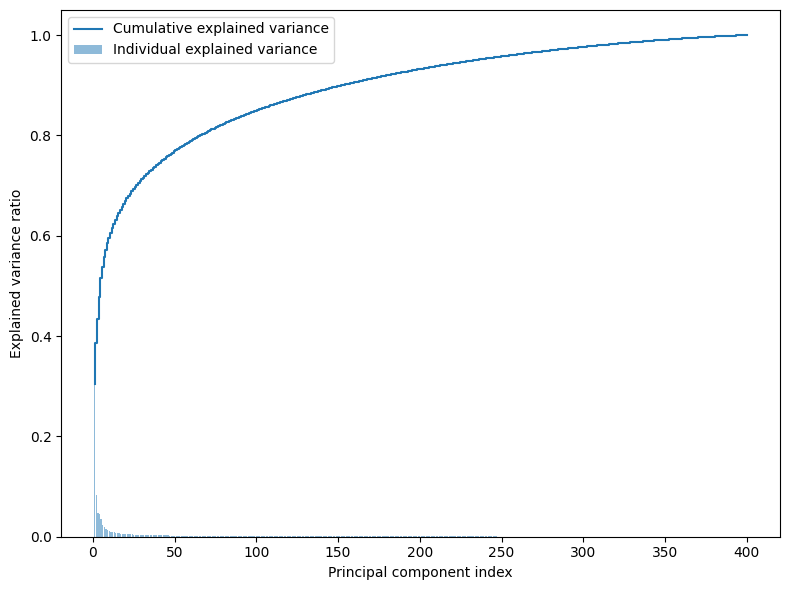

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Assuming 'X_balanced' is your data matrix
# Here we're using a small random dataset as an example
# Replace this with: X_balanced = YOUR_DATA
# X_balanced = np.random.rand(100, 10)

pca = PCA()
pca.fit(X_balanced)

# Calculate the percentage of variance explained by each of the selected components
variance_explained = pca.explained_variance_ratio_

# Cumulative variance explained
cumulative_variance_explained = np.cumsum(variance_explained)

# Plot
plt.figure(figsize=(8, 6))
plt.bar(range(1, len(variance_explained) + 1), variance_explained, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(1, len(cumulative_variance_explained) + 1), cumulative_variance_explained, where='mid', label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()


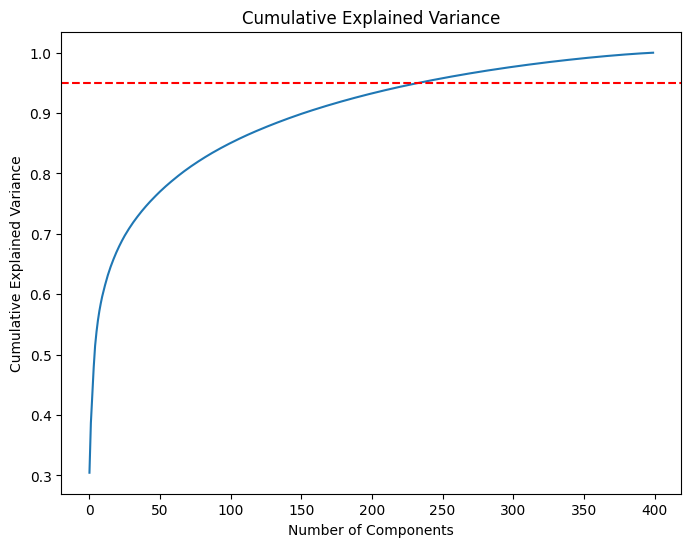

In [45]:
plt.figure(figsize=(8, 6))
plt.plot(cumulative_variance_explained)
plt.axhline(y=0.95, color='r', linestyle='--')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

# Find the number of components that explain 95% variance
n_components_95 = np.where(cumulative_variance_explained >= 0.95)[0][0] + 1


In [46]:
np.where(cumulative_variance_explained > .95)

(array([233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245,
        246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258,
        259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271,
        272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284,
        285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297,
        298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310,
        311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323,
        324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336,
        337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349,
        350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362,
        363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375,
        376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388,
        389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399]),)

# 2 mismatch expected vs unexpected

In [129]:
def categorize(row):
    if (row['cue'] == 'high_cue' and row['stimulusintensity'] == 'high_stim') or (row['cue'] == 'low_cue' and row['stimulusintensity'] == 'low_stim'):
        return 'expected'
    elif (row['cue'] == 'low_cue' and row['stimulusintensity'] == 'high_stim') or (row['cue'] == 'high_cue' and row['stimulusintensity'] == 'low_stim'):
        return 'unexpected'
    elif row['stimulusintensity'] == 'med_stim':
        return 'ambiguous'
    else:
        return 'unknown'  # Just in case there are other combinations


In [130]:

pain_index = cleanbehdf[cleanbehdf['runtype'] == 'pain'].index
df_pain = cleanbehdf[cleanbehdf['runtype'] == 'pain'].copy().reset_index(drop=True)
# df_pain['ses_cue'] = df_pain['ses'].astype(str) +'_' +df_pain['cue'].astype(str)
df_pain['expected'] = df_pain.apply(categorize, axis=1)
Yinterim, uniques = pd.factorize(df_pain['expected'])
groups = pd.factorize(df_pain['sub'])
X = braindf[pain_index]
Y = Yinterim


In [133]:
df_pain.head()

,singletrial_fname,sub,ses,run,runtype,event,trial_index,cue,stimulusintensity,index,expectrating,expectlabel,outcomerating,outcomelabel,stim_con,cue_con,expected
0,sub-0002_ses-03_run-02_runtype-pain_event-stim...,sub-0002,ses-03,run-02,pain,stimulus,9,high_cue,high_stim,0,87.26,Very Strong,70.33,Very Strong,1,1,expected
1,sub-0002_ses-03_run-02_runtype-pain_event-stim...,sub-0002,ses-03,run-02,pain,stimulus,2,low_cue,low_stim,6,60.28,Strong,41.10,Strong,-1,-1,expected
2,sub-0002_ses-03_run-02_runtype-pain_event-stim...,sub-0002,ses-03,run-02,pain,stimulus,10,low_cue,med_stim,8,31.40,Strong,54.01,Strong,0,-1,ambiguous
3,sub-0002_ses-03_run-02_runtype-pain_event-stim...,sub-0002,ses-03,run-02,pain,stimulus,4,high_cue,med_stim,13,113.89,Strongest sensation of any kind,60.03,Strong,0,1,ambiguous
4,sub-0002_ses-03_run-02_runtype-pain_event-stim...,sub-0002,ses-03,run-02,pain,stimulus,11,low_cue,high_stim,28,4.59,Weak,32.42,Strong,1,-1,unexpected


### balancer

In [134]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupKFold
from sklearn.utils import resample

# Given variables: X (data array), Y (factorized labels), groups (array of group labels)

# Convert groups to an array if it's not already
groups_array = np.array(groups[0])

# Find unique groups
unique_groups = np.unique(groups_array)

# Initialize lists to hold the balanced dataset
X_balanced = []
Y_balanced = []
groups_balanced = []

for group in unique_groups:
    # print(group)
    # Indices for the current group
    group_indices = np.where(groups_array == group)[0]
    print(group)
    # Extract current group's data and labels
    X_group = X[group_indices]
    Y_group = Y[group_indices]
    
    # Get the smallest class size within this group
    min_class_size = min(np.bincount(Y_group).min(), group_indices.size)
    if min_class_size > 0:
        # Initialize temporary lists for the group's balanced data
        X_group_balanced = []
        Y_group_balanced = []
        
        # Balance each class within the group
        for class_label in np.unique(Y_group):
            # print(class_label)
            # Indices for the current class within the group
            class_indices = np.where(Y_group == class_label)[0]
            
            # Resample the class to the target size
            resampled_indices = resample(class_indices, n_samples=min_class_size, replace=False, random_state=42)
            
            # Append resampled data and labels to the group's temporary lists
            X_group_balanced.append(X_group[resampled_indices])
            Y_group_balanced.append(Y_group[resampled_indices])
        
        # Concatenate balanced data for the current group and append to the overall balanced lists
        X_balanced.append(np.vstack(X_group_balanced))
        Y_balanced.append(np.concatenate(Y_group_balanced))
        groups_balanced += [group] * min_class_size * len(np.unique(Y_group))
    else:
        print("f{group} does not have trials in one of the classes")

# Concatenate all balanced data from each group to form the final balanced dataset
X_balanced = np.vstack(X_balanced)
Y_balanced = np.concatenate(Y_balanced)
groups_balanced = np.array(groups_balanced)

# Now, X_balanced, Y_balanced, and groups_balanced contain your balanced dataset respecting the original group structure


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98


In [135]:
# Check frequency of balanced data

# 1) Count the number of Y values per group
unique_groups = np.unique(groups_balanced)
group_counts = {group: np.bincount(Y_balanced[groups_balanced == group], minlength=len(np.unique(Y_balanced))) for group in unique_groups}

# 2) Convert to DataFrame for nicer display
df_group_counts = pd.DataFrame(group_counts, index=[f'Class {i}' for i in range(len(np.unique(Y_balanced)))])

df_group_counts


,0,1,2,3,4,5,6,7,8,9,...,89,90,91,92,93,94,95,96,97,98
Class 0,4,16,16,16,8,17,8,16,12,16,...,7,24,16,23,16,23,24,16,12,24
Class 1,4,16,16,16,8,17,8,16,12,16,...,7,24,16,23,16,23,24,16,12,24
Class 2,4,16,16,16,8,17,8,16,12,16,...,7,24,16,23,16,23,24,16,12,24


In [136]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import time

# This code essentially performs 10-fold cross-validation with a Support Vector Machine classifier 
# to evaluate the model's performance on the given brain data and labels, ensuring that the cross-
# validation process is stratified and group-wise. The mean accuracy provides an estimate of how 
# well the SVM model generalizes to unseen data.
# # X: brain data. shape: (number of trials, number of voxels)
# # Y: 1D array with labels (0 for pain, 1 for vicarious, 2 for cognitive)

# 10-fold stratified cross validation
# folds are applied on subject level data
# A linear SVM classifer is trained on the training data and applied on the test data, by predicting 
# the labels on the test data. Accuracies compiles the model accuracy of predicting the labels across the 10 folds. 


# Initialize arrays to store results
accuracies = []



start_time = time.perf_counter()
outer_cv = GroupKFold(n_splits=10)
# pls_model = PLSRegression(n_components=3)
i = 0
scores = []
weights_per_fold = []
coefficients = []
yloadings = []
y_pred_probas = []
y_tests = []
for i, (train_idx, test_idx) in enumerate(outer_cv.split(X_balanced, Y_balanced, groups_balanced)):
    X_train, X_test = X_balanced[train_idx], X_balanced[test_idx]
    Y_train, Y_test = Y_balanced[train_idx], Y_balanced[test_idx]
    
    # Initialize and train a Support Vector Machine (SVM) classifier
    svm = SVC(kernel='linear', decision_function_shape='ovr')  # One-vs-Rest
    svm.fit(X_train, Y_train)
    
    # Predict using the trained model
    Y_pred = svm.predict(X_test)
    accuracy = accuracy_score(Y_test, Y_pred)
    accuracies.append(accuracy)
    weights = svm.coef_
    weights_per_fold.append(weights)
    y_tests.append(Y_test)
# Calculate the mean accuracy across all folds
mean_accuracy = np.mean(accuracies)

# Display the mean accuracy
print(f"Mean Accuracy: {mean_accuracy * 100:.2f}%")
end_time = time.perf_counter()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")


Mean Accuracy: 33.80%
Elapsed time: 314.85402867599623 seconds


## confusion matrix

In [138]:
uniques

Index(['expected', 'ambiguous', 'unexpected'], dtype='object')

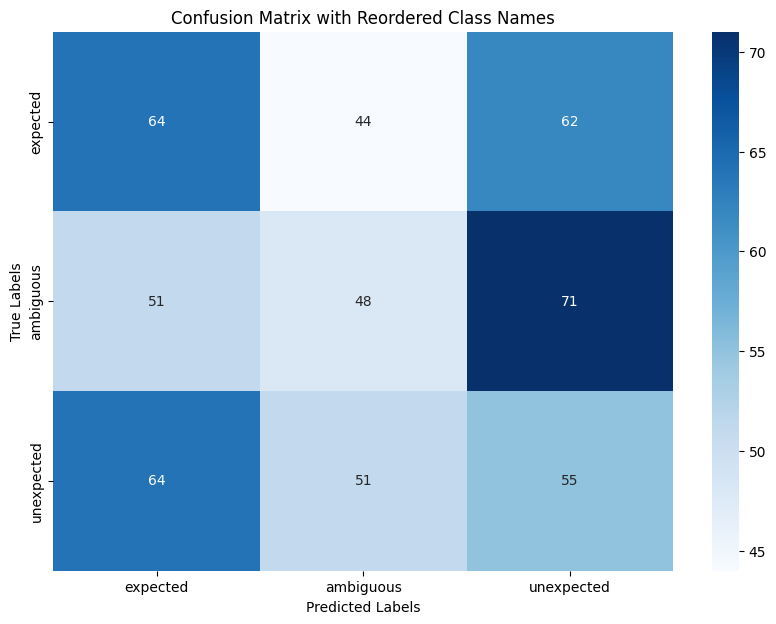

In [137]:
original_class_names = np.array(uniques)
# The desired order for the classes
desired_class_order = ['expected', 'ambiguous', 'unexpected'
                       ]


# Create a dictionary that maps the original indices to the desired class order
class_mapping = {np.where(uniques == name)[0][0]: desired_index
                 for desired_index, name in enumerate(desired_class_order)}


Y_test_remapped = np.vectorize(class_mapping.get)(Y_test)
Y_pred_remapped = np.vectorize(class_mapping.get)(Y_pred)

# Compute the confusion matrix using the remapped labels
cm = confusion_matrix(Y_test_remapped, Y_pred_remapped)

# Plotting the confusion matrix with class labels in the desired order
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=desired_class_order, yticklabels=desired_class_order)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix with Reordered Class Names')
plt.show()

# 3 expect vs. ambiguous over sessions

In [150]:
filtered_df_pain

,singletrial_fname,sub,ses,run,runtype,event,trial_index,cue,stimulusintensity,index,expectrating,expectlabel,outcomerating,outcomelabel,stim_con,cue_con,expected,ses_expected
0,sub-0002_ses-03_run-02_runtype-pain_event-stim...,sub-0002,ses-03,run-02,pain,stimulus,9,high_cue,high_stim,0,87.26,Very Strong,70.33,Very Strong,1,1,expected,ses-03_expected
1,sub-0002_ses-03_run-02_runtype-pain_event-stim...,sub-0002,ses-03,run-02,pain,stimulus,2,low_cue,low_stim,6,60.28,Strong,41.10,Strong,-1,-1,expected,ses-03_expected
2,sub-0002_ses-03_run-02_runtype-pain_event-stim...,sub-0002,ses-03,run-02,pain,stimulus,10,low_cue,med_stim,8,31.40,Strong,54.01,Strong,0,-1,ambiguous,ses-03_ambiguous
3,sub-0002_ses-03_run-02_runtype-pain_event-stim...,sub-0002,ses-03,run-02,pain,stimulus,4,high_cue,med_stim,13,113.89,Strongest sensation of any kind,60.03,Strong,0,1,ambiguous,ses-03_ambiguous
5,sub-0002_ses-03_run-02_runtype-pain_event-stim...,sub-0002,ses-03,run-02,pain,stimulus,5,high_cue,high_stim,41,97.83,Very Strong,63.64,Strong,1,1,expected,ses-03_expected
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5209,sub-0133_ses-04_run-05_runtype-pain_event-stim...,sub-0133,ses-04,run-05,pain,stimulus,9,high_cue,med_stim,17083,69.27,Very Strong,57.65,Strong,0,1,ambiguous,ses-04_ambiguous
5211,sub-0133_ses-03_run-01_runtype-pain_event-stim...,sub-0133,ses-03,run-01,pain,stimulus,11,high_cue,high_stim,17089,56.12,Strong,70.76,Very Strong,1,1,expected,ses-03_expected
5212,sub-0133_ses-01_run-06_runtype-pain_event-stim...,sub-0133,ses-01,run-06,pain,stimulus,1,low_cue,low_stim,17092,32.74,Strong,27.29,Moderate,-1,-1,expected,ses-01_expected
5213,sub-0133_ses-03_run-06_runtype-pain_event-stim...,sub-0133,ses-03,run-06,pain,stimulus,11,high_cue,med_stim,17101,84.64,Very Strong,72.37,Very Strong,0,1,ambiguous,ses-03_ambiguous


In [149]:

pain_index = cleanbehdf[cleanbehdf['runtype'] == 'pain'].index
df_pain = cleanbehdf[cleanbehdf['runtype'] == 'pain'].copy().reset_index(drop=True)

df_pain['expected'] = df_pain.apply(categorize, axis=1)
filtered_df_pain = df_pain[df_pain['expected'].isin(['expected', 'ambiguous'])]
filtered_indices = filtered_df_pain.index

filtered_df_pain['ses_expected'] = filtered_df_pain['ses'].astype(str) +'_' +filtered_df_pain['expected'].astype(str)
Yinterim, uniques = pd.factorize(filtered_df_pain['ses_expected'])
groups = pd.factorize(filtered_df_pain['sub'])
X = braindf[filtered_indices]
Y = Yinterim


/var/folders/bv/b3r94k7n0bq727c1_2xtykpw0000gp/T/ipykernel_42531/545867193.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_pain['ses_expected'] = filtered_df_pain['ses'].astype(str) +'_' +filtered_df_pain['expected'].astype(str)


### expect preproc 1. balancer

In [151]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupKFold
from sklearn.utils import resample

# Given variables: X (data array), Y (factorized labels), groups (array of group labels)

# Convert groups to an array if it's not already
groups_array = np.array(groups[0])

# Find unique groups
unique_groups = np.unique(groups_array)

# Initialize lists to hold the balanced dataset
X_balanced = []
Y_balanced = []
groups_balanced = []

for group in unique_groups:
    # print(group)
    # Indices for the current group
    group_indices = np.where(groups_array == group)[0]
    print(group)
    # Extract current group's data and labels
    X_group = X[group_indices]
    Y_group = Y[group_indices]
    
    # Get the smallest class size within this group
    min_class_size = min(np.bincount(Y_group).min(), group_indices.size)
    if min_class_size > 0:
        # Initialize temporary lists for the group's balanced data
        X_group_balanced = []
        Y_group_balanced = []
        
        # Balance each class within the group
        for class_label in np.unique(Y_group):
            # print(class_label)
            # Indices for the current class within the group
            class_indices = np.where(Y_group == class_label)[0]
            
            # Resample the class to the target size
            resampled_indices = resample(class_indices, n_samples=min_class_size, replace=False, random_state=42)
            
            # Append resampled data and labels to the group's temporary lists
            X_group_balanced.append(X_group[resampled_indices])
            Y_group_balanced.append(Y_group[resampled_indices])
        
        # Concatenate balanced data for the current group and append to the overall balanced lists
        X_balanced.append(np.vstack(X_group_balanced))
        Y_balanced.append(np.concatenate(Y_group_balanced))
        groups_balanced += [group] * min_class_size * len(np.unique(Y_group))
    else:
        print("f{group} does not have trials in one of the classes")

# Concatenate all balanced data from each group to form the final balanced dataset
X_balanced = np.vstack(X_balanced)
Y_balanced = np.concatenate(Y_balanced)
groups_balanced = np.array(groups_balanced)

# Now, X_balanced, Y_balanced, and groups_balanced contain your balanced dataset respecting the original group structure


0
1
2
3
4
f{group} does not have trials in one of the classes
5
6
f{group} does not have trials in one of the classes
7
8
9
10
f{group} does not have trials in one of the classes
11
12
13
14
f{group} does not have trials in one of the classes
15
16
f{group} does not have trials in one of the classes
17
18
19
20
f{group} does not have trials in one of the classes
21
22
23
24
f{group} does not have trials in one of the classes
25
f{group} does not have trials in one of the classes
26
f{group} does not have trials in one of the classes
27
28
29
f{group} does not have trials in one of the classes
30
31
32
33
34
35
36
37
38
f{group} does not have trials in one of the classes
39
40
41
42
f{group} does not have trials in one of the classes
43
f{group} does not have trials in one of the classes
44
f{group} does not have trials in one of the classes
45
f{group} does not have trials in one of the classes
46
f{group} does not have trials in one of the classes
47
48
49
f{group} does not have trial

## expect preproc 2. check number of trials per cell

In [152]:
# Check frequency of balanced data

# 1) Count the number of Y values per group
unique_groups = np.unique(groups_balanced)
group_counts = {group: np.bincount(Y_balanced[groups_balanced == group], minlength=len(np.unique(Y_balanced))) for group in unique_groups}

# 2) Convert to DataFrame for nicer display
df_group_counts = pd.DataFrame(group_counts, index=[f'Class {i}' for i in range(len(np.unique(Y_balanced)))])

df_group_counts


,0,1,2,3,5,7,8,9,11,12,...,83,84,88,90,92,94,95,96,97,98
Class 0,4,8,8,8,1,8,4,8,4,7,...,8,7,8,8,7,8,8,4,1,8
Class 1,4,8,8,8,1,8,4,8,4,7,...,8,7,8,8,7,8,8,4,1,8
Class 2,0,8,8,8,1,8,4,8,0,7,...,8,7,8,8,7,8,8,4,1,8
Class 3,0,8,8,8,1,8,4,8,0,7,...,8,7,8,8,7,8,8,4,1,8
Class 4,0,0,0,0,1,0,0,0,0,7,...,8,7,8,8,7,8,8,4,1,8
Class 5,0,0,0,0,1,0,0,0,0,7,...,8,7,8,8,7,8,8,4,1,8


In [153]:
# Assuming you have a dictionary like group_counts from your previous message,
# where the keys are group identifiers and the values are the counts of each class within that group.

# Identify groups that lack at least one trial in any class
groups_to_remove = [group for group, counts in group_counts.items() if any(count == 0 for count in counts)]
# Convert to boolean mask where True indicates the group should be kept
mask = ~np.isin(groups_balanced, groups_to_remove)

# Apply mask to filter out the identified groups
groups_balanced_filtered = groups_balanced[mask]
Y_balanced_filtered = Y_balanced[mask]
X_balanced_filtered = X_balanced[mask]


In [154]:
# recheck trial distribution
unique_groups = np.unique(groups_balanced_filtered)
group_counts = {group: np.bincount(Y_balanced_filtered[groups_balanced_filtered == group], minlength=len(np.unique(Y_balanced_filtered))) for group in unique_groups}

# 2) Convert to DataFrame for nicer display
df_group_counts = pd.DataFrame(group_counts, index=[f'Class {i}' for i in range(len(np.unique(Y_balanced_filtered)))])

df_group_counts


,5,12,15,17,18,19,21,22,23,27,...,83,84,88,90,92,94,95,96,97,98
Class 0,1,7,8,8,4,8,8,8,7,7,...,8,7,8,8,7,8,8,4,1,8
Class 1,1,7,8,8,4,8,8,8,7,7,...,8,7,8,8,7,8,8,4,1,8
Class 2,1,7,8,8,4,8,8,8,7,7,...,8,7,8,8,7,8,8,4,1,8
Class 3,1,7,8,8,4,8,8,8,7,7,...,8,7,8,8,7,8,8,4,1,8
Class 4,1,7,8,8,4,8,8,8,7,7,...,8,7,8,8,7,8,8,4,1,8
Class 5,1,7,8,8,4,8,8,8,7,7,...,8,7,8,8,7,8,8,4,1,8


## SVM

In [155]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import time

# This code essentially performs 10-fold cross-validation with a Support Vector Machine classifier 
# to evaluate the model's performance on the given brain data and labels, ensuring that the cross-
# validation process is stratified and group-wise. The mean accuracy provides an estimate of how 
# well the SVM model generalizes to unseen data.
# # X: brain data. shape: (number of trials, number of voxels)
# # Y: 1D array with labels (0 for pain, 1 for vicarious, 2 for cognitive)

# 10-fold stratified cross validation
# folds are applied on subject level data
# A linear SVM classifer is trained on the training data and applied on the test data, by predicting 
# the labels on the test data. Accuracies compiles the model accuracy of predicting the labels across the 10 folds. 


# Initialize arrays to store results
accuracies = []



start_time = time.perf_counter()
outer_cv = GroupKFold(n_splits=10)
# pls_model = PLSRegression(n_components=3)
i = 0
scores = []
weights_per_fold = []
coefficients = []
yloadings = []
y_pred_probas = []
y_tests = []
for i, (train_idx, test_idx) in enumerate(outer_cv.split(X_balanced_filtered, Y_balanced_filtered, groups_balanced_filtered)):
    X_train, X_test = X_balanced_filtered[train_idx], X_balanced_filtered[test_idx]
    Y_train, Y_test = Y_balanced_filtered[train_idx], Y_balanced_filtered[test_idx]
    
    # Initialize and train a Support Vector Machine (SVM) classifier
    svm = SVC(kernel='linear', decision_function_shape='ovr')  # One-vs-Rest
    svm.fit(X_train, Y_train)
    
    # Predict using the trained model
    Y_pred = svm.predict(X_test)
    accuracy = accuracy_score(Y_test, Y_pred)
    accuracies.append(accuracy)
    weights = svm.coef_
    weights_per_fold.append(weights)
    y_tests.append(Y_test)
# Calculate the mean accuracy across all folds
mean_accuracy = np.mean(accuracies)

# Display the mean accuracy
print(f"Mean Accuracy: {mean_accuracy * 100:.2f}%")
end_time = time.perf_counter()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")


Mean Accuracy: 16.34%
Elapsed time: 52.3337353120005 seconds


In [157]:
original_class_names = np.array(uniques)
original_class_names

array(['ses-03_expected', 'ses-03_ambiguous', 'ses-04_ambiguous',
       'ses-04_expected', 'ses-01_expected', 'ses-01_ambiguous'],
      dtype=object)

## confusion matrix

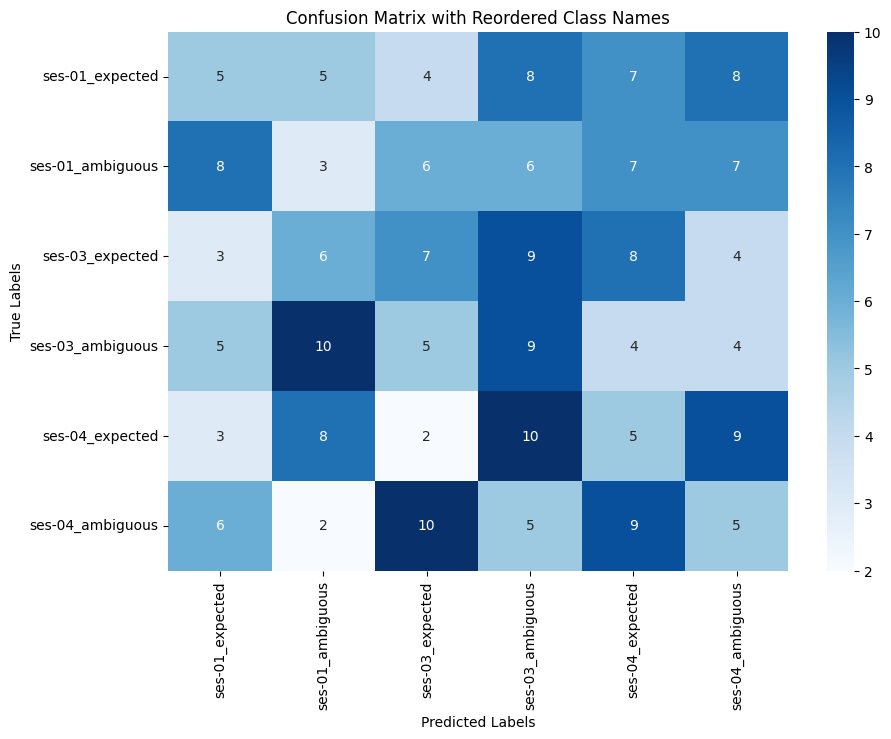

In [158]:
original_class_names = np.array(uniques)
# The desired order for the classes
desired_class_order = [ 'ses-01_expected', 'ses-01_ambiguous', 
                       'ses-03_expected', 'ses-03_ambiguous', 
                       'ses-04_expected', 'ses-04_ambiguous', 
                       ]


# Create a dictionary that maps the original indices to the desired class order
class_mapping = {np.where(uniques == name)[0][0]: desired_index
                 for desired_index, name in enumerate(desired_class_order)}


Y_test_remapped = np.vectorize(class_mapping.get)(Y_test)
Y_pred_remapped = np.vectorize(class_mapping.get)(Y_pred)

# Compute the confusion matrix using the remapped labels
cm = confusion_matrix(Y_test_remapped, Y_pred_remapped)

# Plotting the confusion matrix with class labels in the desired order
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=desired_class_order, yticklabels=desired_class_order)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix with Reordered Class Names')
plt.show()

# 4 mismatch unexpected vs ambiguous

In [159]:

pain_index = cleanbehdf[cleanbehdf['runtype'] == 'pain'].index
df_pain = cleanbehdf[cleanbehdf['runtype'] == 'pain'].copy().reset_index(drop=True)

df_pain['expected'] = df_pain.apply(categorize, axis=1)
filtered_df_pain = df_pain[df_pain['expected'].isin(['unexpected', 'ambiguous'])]
filtered_indices = filtered_df_pain.index

filtered_df_pain['ses_expected'] = filtered_df_pain['ses'].astype(str) +'_' +filtered_df_pain['expected'].astype(str)
Yinterim, uniques = pd.factorize(filtered_df_pain['ses_expected'])
groups = pd.factorize(filtered_df_pain['sub'])
X = braindf[filtered_indices]
Y = Yinterim


# balancer _____________________________________________________________________
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupKFold
from sklearn.utils import resample

# Given variables: X (data array), Y (factorized labels), groups (array of group labels)

# Convert groups to an array if it's not already
groups_array = np.array(groups[0])

# Find unique groups
unique_groups = np.unique(groups_array)

# Initialize lists to hold the balanced dataset
X_balanced = []
Y_balanced = []
groups_balanced = []

for group in unique_groups:
    # print(group)
    # Indices for the current group
    group_indices = np.where(groups_array == group)[0]
    print(group)
    # Extract current group's data and labels
    X_group = X[group_indices]
    Y_group = Y[group_indices]
    
    # Get the smallest class size within this group
    min_class_size = min(np.bincount(Y_group).min(), group_indices.size)
    if min_class_size > 0:
        # Initialize temporary lists for the group's balanced data
        X_group_balanced = []
        Y_group_balanced = []
        
        # Balance each class within the group
        for class_label in np.unique(Y_group):
            # print(class_label)
            # Indices for the current class within the group
            class_indices = np.where(Y_group == class_label)[0]
            
            # Resample the class to the target size
            resampled_indices = resample(class_indices, n_samples=min_class_size, replace=False, random_state=42)
            
            # Append resampled data and labels to the group's temporary lists
            X_group_balanced.append(X_group[resampled_indices])
            Y_group_balanced.append(Y_group[resampled_indices])
        
        # Concatenate balanced data for the current group and append to the overall balanced lists
        X_balanced.append(np.vstack(X_group_balanced))
        Y_balanced.append(np.concatenate(Y_group_balanced))
        groups_balanced += [group] * min_class_size * len(np.unique(Y_group))
    else:
        print("f{group} does not have trials in one of the classes")

# Concatenate all balanced data from each group to form the final balanced dataset
X_balanced = np.vstack(X_balanced)
Y_balanced = np.concatenate(Y_balanced)
groups_balanced = np.array(groups_balanced)

# Now, X_balanced, Y_balanced, and groups_balanced contain your balanced dataset respecting the original group structure
# Check frequency of balanced data

# 1) Count the number of Y values per group
unique_groups = np.unique(groups_balanced)
group_counts = {group: np.bincount(Y_balanced[groups_balanced == group], minlength=len(np.unique(Y_balanced))) for group in unique_groups}

# 2) Convert to DataFrame for nicer display
df_group_counts = pd.DataFrame(group_counts, index=[f'Class {i}' for i in range(len(np.unique(Y_balanced)))])

df_group_counts



0
1
2
3
4
f{group} does not have trials in one of the classes
5
6
f{group} does not have trials in one of the classes
7
8
9
10
f{group} does not have trials in one of the classes
11
12
13
14
f{group} does not have trials in one of the classes
15
16
f{group} does not have trials in one of the classes
17
18
19
20
f{group} does not have trials in one of the classes
21
22
23
24
f{group} does not have trials in one of the classes
25
f{group} does not have trials in one of the classes
26
f{group} does not have trials in one of the classes
27
28
29
f{group} does not have trials in one of the classes
30
31
32
33
34
35
36
37
38
f{group} does not have trials in one of the classes
39
40
41
42
f{group} does not have trials in one of the classes
43
f{group} does not have trials in one of the classes
44
f{group} does not have trials in one of the classes
45
f{group} does not have trials in one of the classes
46
f{group} does not have trials in one of the classes
47
48
49
f{group} does not have trial

/var/folders/bv/b3r94k7n0bq727c1_2xtykpw0000gp/T/ipykernel_42531/740369891.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_pain['ses_expected'] = filtered_df_pain['ses'].astype(str) +'_' +filtered_df_pain['expected'].astype(str)


,0,1,2,3,5,7,8,9,11,12,...,81,83,84,88,90,92,94,95,96,98
Class 0,4,8,8,8,2,8,4,8,4,8,...,4,8,8,8,8,8,7,8,4,8
Class 1,4,8,8,8,2,8,4,8,4,8,...,4,8,8,8,8,8,7,8,4,8
Class 2,0,8,8,8,2,8,4,8,0,8,...,4,8,8,8,8,8,7,8,4,8
Class 3,0,8,8,8,2,8,4,8,0,8,...,4,8,8,8,8,8,7,8,4,8
Class 4,0,0,0,0,2,0,0,0,0,8,...,4,8,8,8,8,8,7,8,4,8
Class 5,0,0,0,0,2,0,0,0,0,8,...,4,8,8,8,8,8,7,8,4,8


In [ ]:
# Assuming you have a dictionary like group_counts from your previous message,
# where the keys are group identifiers and the values are the counts of each class within that group.

# Identify groups that lack at least one trial in any class
groups_to_remove = [group for group, counts in group_counts.items() if any(count == 0 for count in counts)]
# Convert to boolean mask where True indicates the group should be kept
mask = ~np.isin(groups_balanced, groups_to_remove)

# Apply mask to filter out the identified groups
groups_balanced_filtered = groups_balanced[mask]
Y_balanced_filtered = Y_balanced[mask]
X_balanced_filtered = X_balanced[mask]

# recheck trial distribution
unique_groups = np.unique(groups_balanced_filtered)
group_counts = {group: np.bincount(Y_balanced_filtered[groups_balanced_filtered == group], minlength=len(np.unique(Y_balanced_filtered))) for group in unique_groups}

# 2) Convert to DataFrame for nicer display
df_group_counts = pd.DataFrame(group_counts, index=[f'Class {i}' for i in range(len(np.unique(Y_balanced_filtered)))])

df_group_counts



In [160]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import time

# This code essentially performs 10-fold cross-validation with a Support Vector Machine classifier 
# to evaluate the model's performance on the given brain data and labels, ensuring that the cross-
# validation process is stratified and group-wise. The mean accuracy provides an estimate of how 
# well the SVM model generalizes to unseen data.
# # X: brain data. shape: (number of trials, number of voxels)
# # Y: 1D array with labels (0 for pain, 1 for vicarious, 2 for cognitive)

# 10-fold stratified cross validation
# folds are applied on subject level data
# A linear SVM classifer is trained on the training data and applied on the test data, by predicting 
# the labels on the test data. Accuracies compiles the model accuracy of predicting the labels across the 10 folds. 


# Initialize arrays to store results
accuracies = []



start_time = time.perf_counter()
outer_cv = GroupKFold(n_splits=10)
# pls_model = PLSRegression(n_components=3)
i = 0
scores = []
weights_per_fold = []
coefficients = []
yloadings = []
y_pred_probas = []
y_tests = []
for i, (train_idx, test_idx) in enumerate(outer_cv.split(X_balanced_filtered, Y_balanced_filtered, groups_balanced_filtered)):
    X_train, X_test = X_balanced_filtered[train_idx], X_balanced_filtered[test_idx]
    Y_train, Y_test = Y_balanced_filtered[train_idx], Y_balanced_filtered[test_idx]
    
    # Initialize and train a Support Vector Machine (SVM) classifier
    svm = SVC(kernel='linear', decision_function_shape='ovr')  # One-vs-Rest
    svm.fit(X_train, Y_train)
    
    # Predict using the trained model
    Y_pred = svm.predict(X_test)
    accuracy = accuracy_score(Y_test, Y_pred)
    accuracies.append(accuracy)
    weights = svm.coef_
    weights_per_fold.append(weights)
    y_tests.append(Y_test)
# Calculate the mean accuracy across all folds
mean_accuracy = np.mean(accuracies)

# Display the mean accuracy
print(f"Mean Accuracy: {mean_accuracy * 100:.2f}%")
end_time = time.perf_counter()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")


Mean Accuracy: 16.34%
Elapsed time: 52.51908377300424 seconds


In [161]:
original_class_names = np.array(uniques)
original_class_names

array(['ses-03_ambiguous', 'ses-03_unexpected', 'ses-04_ambiguous',
       'ses-04_unexpected', 'ses-01_ambiguous', 'ses-01_unexpected'],
      dtype=object)

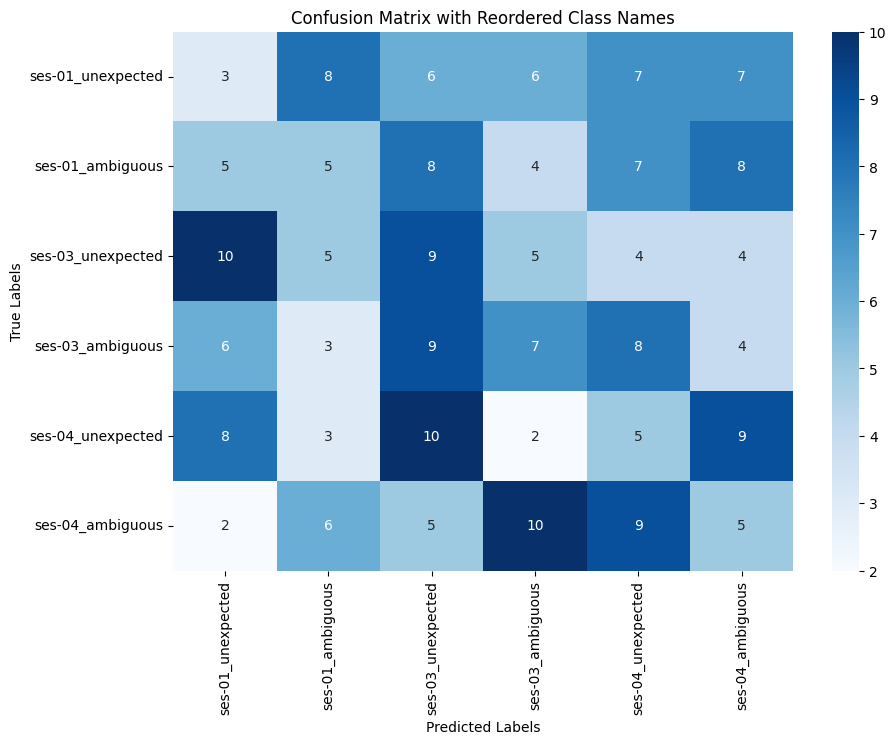

In [162]:
original_class_names = np.array(uniques)
# The desired order for the classes
desired_class_order = [ 'ses-01_unexpected', 'ses-01_ambiguous', 
                       'ses-03_unexpected', 'ses-03_ambiguous', 
                       'ses-04_unexpected', 'ses-04_ambiguous', 
                       ]


# Create a dictionary that maps the original indices to the desired class order
class_mapping = {np.where(uniques == name)[0][0]: desired_index
                 for desired_index, name in enumerate(desired_class_order)}


Y_test_remapped = np.vectorize(class_mapping.get)(Y_test)
Y_pred_remapped = np.vectorize(class_mapping.get)(Y_pred)

# Compute the confusion matrix using the remapped labels
cm = confusion_matrix(Y_test_remapped, Y_pred_remapped)

# Plotting the confusion matrix with class labels in the desired order
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=desired_class_order, yticklabels=desired_class_order)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix with Reordered Class Names')
plt.show()

# 5 mismatch expected vs unexpected (session)

In [164]:

pain_index = cleanbehdf[cleanbehdf['runtype'] == 'pain'].index
df_pain = cleanbehdf[cleanbehdf['runtype'] == 'pain'].copy().reset_index(drop=True)

df_pain['expected'] = df_pain.apply(categorize, axis=1)
filtered_df_pain = df_pain[df_pain['expected'].isin(['expected', 'unexpected'])]
filtered_indices = filtered_df_pain.index

filtered_df_pain['ses_expected'] = filtered_df_pain['ses'].astype(str) +'_' +filtered_df_pain['expected'].astype(str)
Yinterim, uniques = pd.factorize(filtered_df_pain['ses_expected'])
groups = pd.factorize(filtered_df_pain['sub'])
X = braindf[filtered_indices]
Y = Yinterim


# balancer _____________________________________________________________________
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupKFold
from sklearn.utils import resample

# Given variables: X (data array), Y (factorized labels), groups (array of group labels)

# Convert groups to an array if it's not already
groups_array = np.array(groups[0])

# Find unique groups
unique_groups = np.unique(groups_array)

# Initialize lists to hold the balanced dataset
X_balanced = []
Y_balanced = []
groups_balanced = []

for group in unique_groups:
    # print(group)
    # Indices for the current group
    group_indices = np.where(groups_array == group)[0]
    print(group)
    # Extract current group's data and labels
    X_group = X[group_indices]
    Y_group = Y[group_indices]
    
    # Get the smallest class size within this group
    min_class_size = min(np.bincount(Y_group).min(), group_indices.size)
    if min_class_size > 0:
        # Initialize temporary lists for the group's balanced data
        X_group_balanced = []
        Y_group_balanced = []
        
        # Balance each class within the group
        for class_label in np.unique(Y_group):
            # print(class_label)
            # Indices for the current class within the group
            class_indices = np.where(Y_group == class_label)[0]
            
            # Resample the class to the target size
            resampled_indices = resample(class_indices, n_samples=min_class_size, replace=False, random_state=42)
            
            # Append resampled data and labels to the group's temporary lists
            X_group_balanced.append(X_group[resampled_indices])
            Y_group_balanced.append(Y_group[resampled_indices])
        
        # Concatenate balanced data for the current group and append to the overall balanced lists
        X_balanced.append(np.vstack(X_group_balanced))
        Y_balanced.append(np.concatenate(Y_group_balanced))
        groups_balanced += [group] * min_class_size * len(np.unique(Y_group))
    else:
        print("f{group} does not have trials in one of the classes")

# Concatenate all balanced data from each group to form the final balanced dataset
X_balanced = np.vstack(X_balanced)
Y_balanced = np.concatenate(Y_balanced)
groups_balanced = np.array(groups_balanced)

# Now, X_balanced, Y_balanced, and groups_balanced contain your balanced dataset respecting the original group structure
# Check frequency of balanced data

# 1) Count the number of Y values per group
unique_groups = np.unique(groups_balanced)
group_counts = {group: np.bincount(Y_balanced[groups_balanced == group], minlength=len(np.unique(Y_balanced))) for group in unique_groups}

# 2) Convert to DataFrame for nicer display
df_group_counts = pd.DataFrame(group_counts, index=[f'Class {i}' for i in range(len(np.unique(Y_balanced)))])

df_group_counts



0
1
2
3
4
f{group} does not have trials in one of the classes
5
6
f{group} does not have trials in one of the classes
7
8
9
10
f{group} does not have trials in one of the classes
11
12
13
14
f{group} does not have trials in one of the classes
15
16
f{group} does not have trials in one of the classes
17
18
19
20
f{group} does not have trials in one of the classes
21
22
23
24
f{group} does not have trials in one of the classes
25
f{group} does not have trials in one of the classes
26
f{group} does not have trials in one of the classes
27
28
29
f{group} does not have trials in one of the classes
30
31
32
33
34
35
36
37
38
f{group} does not have trials in one of the classes
39
40
41
42
f{group} does not have trials in one of the classes
43
f{group} does not have trials in one of the classes
44
f{group} does not have trials in one of the classes
45
f{group} does not have trials in one of the classes
46
f{group} does not have trials in one of the classes
47
48
49
f{group} does not have trial

/var/folders/bv/b3r94k7n0bq727c1_2xtykpw0000gp/T/ipykernel_42531/2352043624.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_pain['ses_expected'] = filtered_df_pain['ses'].astype(str) +'_' +filtered_df_pain['expected'].astype(str)


,0,1,2,3,5,7,8,9,11,12,...,81,83,84,88,90,92,94,95,96,98
Class 0,4,8,8,8,1,8,4,8,4,7,...,4,8,7,8,8,7,7,8,4,8
Class 1,4,8,8,8,1,8,4,8,4,7,...,4,8,7,8,8,7,7,8,4,8
Class 2,0,8,8,8,1,8,4,8,0,7,...,4,8,7,8,8,7,7,8,4,8
Class 3,0,8,8,8,1,8,4,8,0,7,...,4,8,7,8,8,7,7,8,4,8
Class 4,0,0,0,0,1,0,0,0,0,7,...,4,8,7,8,8,7,7,8,4,8
Class 5,0,0,0,0,1,0,0,0,0,7,...,4,8,7,8,8,7,7,8,4,8


In [165]:
# Assuming you have a dictionary like group_counts from your previous message,
# where the keys are group identifiers and the values are the counts of each class within that group.

# Identify groups that lack at least one trial in any class
groups_to_remove = [group for group, counts in group_counts.items() if any(count == 0 for count in counts)]
# Convert to boolean mask where True indicates the group should be kept
mask = ~np.isin(groups_balanced, groups_to_remove)

# Apply mask to filter out the identified groups
groups_balanced_filtered = groups_balanced[mask]
Y_balanced_filtered = Y_balanced[mask]
X_balanced_filtered = X_balanced[mask]

# recheck trial distribution
unique_groups = np.unique(groups_balanced_filtered)
group_counts = {group: np.bincount(Y_balanced_filtered[groups_balanced_filtered == group], minlength=len(np.unique(Y_balanced_filtered))) for group in unique_groups}

# 2) Convert to DataFrame for nicer display
df_group_counts = pd.DataFrame(group_counts, index=[f'Class {i}' for i in range(len(np.unique(Y_balanced_filtered)))])

df_group_counts



,5,12,15,17,18,19,21,22,23,27,...,81,83,84,88,90,92,94,95,96,98
Class 0,1,7,8,8,4,7,8,8,7,6,...,4,8,7,8,8,7,7,8,4,8
Class 1,1,7,8,8,4,7,8,8,7,6,...,4,8,7,8,8,7,7,8,4,8
Class 2,1,7,8,8,4,7,8,8,7,6,...,4,8,7,8,8,7,7,8,4,8
Class 3,1,7,8,8,4,7,8,8,7,6,...,4,8,7,8,8,7,7,8,4,8
Class 4,1,7,8,8,4,7,8,8,7,6,...,4,8,7,8,8,7,7,8,4,8
Class 5,1,7,8,8,4,7,8,8,7,6,...,4,8,7,8,8,7,7,8,4,8


In [166]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import time

# This code essentially performs 10-fold cross-validation with a Support Vector Machine classifier 
# to evaluate the model's performance on the given brain data and labels, ensuring that the cross-
# validation process is stratified and group-wise. The mean accuracy provides an estimate of how 
# well the SVM model generalizes to unseen data.
# # X: brain data. shape: (number of trials, number of voxels)
# # Y: 1D array with labels (0 for pain, 1 for vicarious, 2 for cognitive)

# 10-fold stratified cross validation
# folds are applied on subject level data
# A linear SVM classifer is trained on the training data and applied on the test data, by predicting 
# the labels on the test data. Accuracies compiles the model accuracy of predicting the labels across the 10 folds. 


# Initialize arrays to store results
accuracies = []



start_time = time.perf_counter()
outer_cv = GroupKFold(n_splits=10)
# pls_model = PLSRegression(n_components=3)
i = 0
scores = []
weights_per_fold = []
coefficients = []
yloadings = []
y_pred_probas = []
y_tests = []
for i, (train_idx, test_idx) in enumerate(outer_cv.split(X_balanced_filtered, Y_balanced_filtered, groups_balanced_filtered)):
    X_train, X_test = X_balanced_filtered[train_idx], X_balanced_filtered[test_idx]
    Y_train, Y_test = Y_balanced_filtered[train_idx], Y_balanced_filtered[test_idx]
    
    # Initialize and train a Support Vector Machine (SVM) classifier
    svm = SVC(kernel='linear', decision_function_shape='ovr')  # One-vs-Rest
    svm.fit(X_train, Y_train)
    
    # Predict using the trained model
    Y_pred = svm.predict(X_test)
    accuracy = accuracy_score(Y_test, Y_pred)
    accuracies.append(accuracy)
    weights = svm.coef_
    weights_per_fold.append(weights)
    y_tests.append(Y_test)
# Calculate the mean accuracy across all folds
mean_accuracy = np.mean(accuracies)

# Display the mean accuracy
print(f"Mean Accuracy: {mean_accuracy * 100:.2f}%")
end_time = time.perf_counter()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")


Mean Accuracy: 17.74%
Elapsed time: 50.035266790000605 seconds


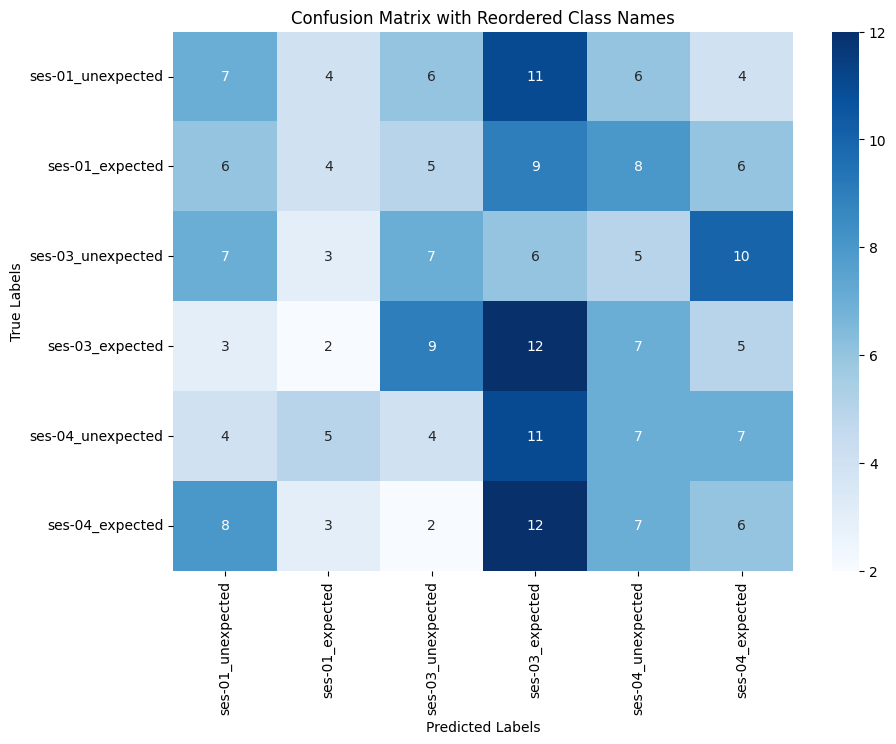

In [168]:
original_class_names = np.array(uniques)
# The desired order for the classes
desired_class_order = [ 'ses-01_unexpected', 'ses-01_expected', 
                       'ses-03_unexpected', 'ses-03_expected', 
                       'ses-04_unexpected', 'ses-04_expected', 
                       ]


# Create a dictionary that maps the original indices to the desired class order
class_mapping = {np.where(uniques == name)[0][0]: desired_index
                 for desired_index, name in enumerate(desired_class_order)}


Y_test_remapped = np.vectorize(class_mapping.get)(Y_test)
Y_pred_remapped = np.vectorize(class_mapping.get)(Y_pred)

# Compute the confusion matrix using the remapped labels
cm = confusion_matrix(Y_test_remapped, Y_pred_remapped)

# Plotting the confusion matrix with class labels in the desired order
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=desired_class_order, yticklabels=desired_class_order)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix with Reordered Class Names')
plt.show()

# 6 mismatch mullover session difference

## balance

In [172]:

pain_index = cleanbehdf[cleanbehdf['runtype'] == 'pain'].index
df_pain = cleanbehdf[cleanbehdf['runtype'] == 'pain'].copy().reset_index(drop=True)
# df_pain['ses_cue'] = df_pain['ses'].astype(str) +'_' +df_pain['cue'].astype(str)
df_pain['expected'] = df_pain.apply(categorize, axis=1)

filtered_df_pain = df_pain[df_pain['expected'].isin(['expected', 'unexpected'])]
filtered_indices = filtered_df_pain.index

# filtered_df_pain['ses_expected'] = filtered_df_pain['ses'].astype(str) +'_' +filtered_df_pain['expected'].astype(str)
Yinterim, uniques = pd.factorize(filtered_df_pain['expected'])
groups = pd.factorize(filtered_df_pain['sub'])
X = braindf[filtered_indices]
Y = Yinterim



# balancer _____________________________________________________________________
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupKFold
from sklearn.utils import resample

# Given variables: X (data array), Y (factorized labels), groups (array of group labels)

# Convert groups to an array if it's not already
groups_array = np.array(groups[0])

# Find unique groups
unique_groups = np.unique(groups_array)

# Initialize lists to hold the balanced dataset
X_balanced = []
Y_balanced = []
groups_balanced = []

for group in unique_groups:
    # print(group)
    # Indices for the current group
    group_indices = np.where(groups_array == group)[0]
    print(group)
    # Extract current group's data and labels
    X_group = X[group_indices]
    Y_group = Y[group_indices]
    
    # Get the smallest class size within this group
    min_class_size = min(np.bincount(Y_group).min(), group_indices.size)
    if min_class_size > 0:
        # Initialize temporary lists for the group's balanced data
        X_group_balanced = []
        Y_group_balanced = []
        
        # Balance each class within the group
        for class_label in np.unique(Y_group):
            # print(class_label)
            # Indices for the current class within the group
            class_indices = np.where(Y_group == class_label)[0]
            
            # Resample the class to the target size
            resampled_indices = resample(class_indices, n_samples=min_class_size, replace=False, random_state=42)
            
            # Append resampled data and labels to the group's temporary lists
            X_group_balanced.append(X_group[resampled_indices])
            Y_group_balanced.append(Y_group[resampled_indices])
        
        # Concatenate balanced data for the current group and append to the overall balanced lists
        X_balanced.append(np.vstack(X_group_balanced))
        Y_balanced.append(np.concatenate(Y_group_balanced))
        groups_balanced += [group] * min_class_size * len(np.unique(Y_group))
    else:
        print("f{group} does not have trials in one of the classes")

# Concatenate all balanced data from each group to form the final balanced dataset
X_balanced = np.vstack(X_balanced)
Y_balanced = np.concatenate(Y_balanced)
groups_balanced = np.array(groups_balanced)

# Now, X_balanced, Y_balanced, and groups_balanced contain your balanced dataset respecting the original group structure
# Check frequency of balanced data

# 1) Count the number of Y values per group
unique_groups = np.unique(groups_balanced)
group_counts = {group: np.bincount(Y_balanced[groups_balanced == group], minlength=len(np.unique(Y_balanced))) for group in unique_groups}

# 2) Convert to DataFrame for nicer display
df_group_counts = pd.DataFrame(group_counts, index=[f'Class {i}' for i in range(len(np.unique(Y_balanced)))])

df_group_counts


# Assuming you have a dictionary like group_counts from your previous message,
# where the keys are group identifiers and the values are the counts of each class within that group.

# Identify groups that lack at least one trial in any class
groups_to_remove = [group for group, counts in group_counts.items() if any(count == 0 for count in counts)]
# Convert to boolean mask where True indicates the group should be kept
mask = ~np.isin(groups_balanced, groups_to_remove)

# Apply mask to filter out the identified groups
groups_balanced_filtered = groups_balanced[mask]
Y_balanced_filtered = Y_balanced[mask]
X_balanced_filtered = X_balanced[mask]

# recheck trial distribution
unique_groups = np.unique(groups_balanced_filtered)
group_counts = {group: np.bincount(Y_balanced_filtered[groups_balanced_filtered == group], minlength=len(np.unique(Y_balanced_filtered))) for group in unique_groups}

# 2) Convert to DataFrame for nicer display
df_group_counts = pd.DataFrame(group_counts, index=[f'Class {i}' for i in range(len(np.unique(Y_balanced_filtered)))])

df_group_counts




0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98


,0,1,2,3,4,5,6,7,8,9,...,89,90,91,92,93,94,95,96,97,98
Class 0,4,16,16,16,8,17,8,16,12,16,...,7,24,16,23,16,23,24,16,12,24
Class 1,4,16,16,16,8,17,8,16,12,16,...,7,24,16,23,16,23,24,16,12,24


In [173]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import time

# This code essentially performs 10-fold cross-validation with a Support Vector Machine classifier 
# to evaluate the model's performance on the given brain data and labels, ensuring that the cross-
# validation process is stratified and group-wise. The mean accuracy provides an estimate of how 
# well the SVM model generalizes to unseen data.
# # X: brain data. shape: (number of trials, number of voxels)
# # Y: 1D array with labels (0 for pain, 1 for vicarious, 2 for cognitive)

# 10-fold stratified cross validation
# folds are applied on subject level data
# A linear SVM classifer is trained on the training data and applied on the test data, by predicting 
# the labels on the test data. Accuracies compiles the model accuracy of predicting the labels across the 10 folds. 


# Initialize arrays to store results
accuracies = []



start_time = time.perf_counter()
outer_cv = GroupKFold(n_splits=10)
# pls_model = PLSRegression(n_components=3)
i = 0
scores = []
weights_per_fold = []
coefficients = []
yloadings = []
y_pred_probas = []
y_tests = []
for i, (train_idx, test_idx) in enumerate(outer_cv.split(X_balanced_filtered, Y_balanced_filtered, groups_balanced_filtered)):
    X_train, X_test = X_balanced_filtered[train_idx], X_balanced_filtered[test_idx]
    Y_train, Y_test = Y_balanced_filtered[train_idx], Y_balanced_filtered[test_idx]
    
    # Initialize and train a Support Vector Machine (SVM) classifier
    svm = SVC(kernel='linear', decision_function_shape='ovr')  # One-vs-Rest
    svm.fit(X_train, Y_train)
    
    # Predict using the trained model
    Y_pred = svm.predict(X_test)
    accuracy = accuracy_score(Y_test, Y_pred)
    accuracies.append(accuracy)
    weights = svm.coef_
    weights_per_fold.append(weights)
    y_tests.append(Y_test)
# Calculate the mean accuracy across all folds
mean_accuracy = np.mean(accuracies)

# Display the mean accuracy
print(f"Mean Accuracy: {mean_accuracy * 100:.2f}%")
end_time = time.perf_counter()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")


Mean Accuracy: 51.17%
Elapsed time: 123.18118689399853 seconds


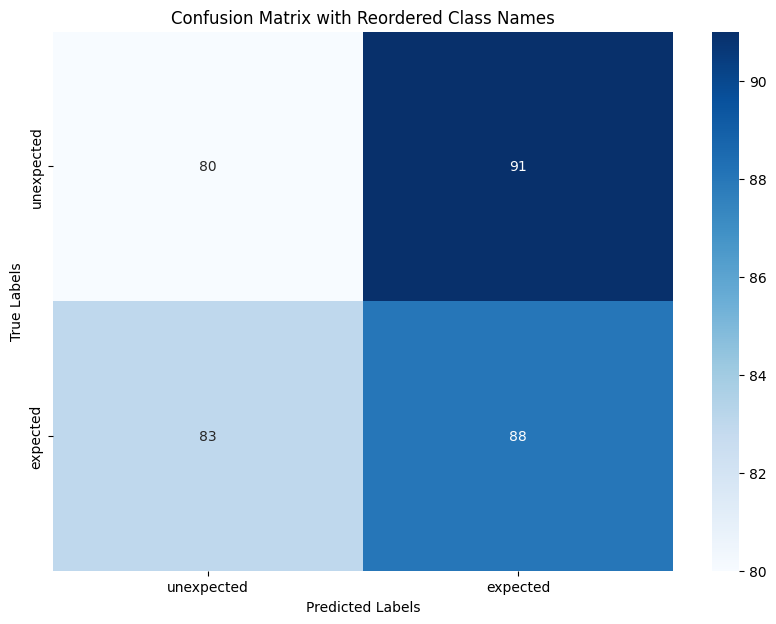

In [174]:
original_class_names = np.array(uniques)
# The desired order for the classes
desired_class_order = [ 'unexpected', 'expected'
                       ]


# Create a dictionary that maps the original indices to the desired class order
class_mapping = {np.where(uniques == name)[0][0]: desired_index
                 for desired_index, name in enumerate(desired_class_order)}


Y_test_remapped = np.vectorize(class_mapping.get)(Y_test)
Y_pred_remapped = np.vectorize(class_mapping.get)(Y_pred)

# Compute the confusion matrix using the remapped labels
cm = confusion_matrix(Y_test_remapped, Y_pred_remapped)

# Plotting the confusion matrix with class labels in the desired order
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=desired_class_order, yticklabels=desired_class_order)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix with Reordered Class Names')
plt.show()